# **2D Dubins Paths | A Guide**

**Goal:** Given a robot’s start pose (position and heading) and a goal pose, find the shortest path that respects the robot’s motion constraints.

## Plotting Helper Functions

Before we get into the geometry of Dubins paths, we’ll set up a few small plotting helpers.

These functions will let us:

- draw the **turning circles** for left/right arcs,  
- visualize the robot’s **heading** as an arrow,  
- draw **straight segments** (tangents / S-segments), and  
- create a clean, square **plotting area** where circles don’t look distorted.

We’ll use these helpers throughout the notebook to build diagrams for LSL, RSR, and the other Dubins path types step by step.


In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt

TAU = 2 * math.pi # TAU = 2π, one full revolution in radians

def plot_circle(center, radius, **kwargs):
    """
    Plot a circle representing a Dubins turning circle.
    Updated to accept standard matplotlib keyword arguments (alpha, linestyle, etc.).
    """
    # Create the circle points
    th = np.linspace(0, 2*math.pi, 100)
    pts = center + radius * np.array([np.cos(th), np.sin(th)]).T
    
    # Handle the old 'style' parameter if it's passed, mapping it to 'linestyle'
    if 'style' in kwargs:
        kwargs['linestyle'] = kwargs.pop('style')
    
    # Set a default color if none is provided
    if 'color' not in kwargs:
        kwargs['color'] = 'gray'
        
    # Plot using standard matplotlib args
    plt.plot(pts[:,0], pts[:,1], **kwargs)

def plot_arrow(p0, heading, length=0.5, color='black'):
    """
    Plot a small arrow to indicate a pose's heading direction.

    Parameters
    ----------
    p0 : array-like of shape (2,)
        Starting point of the arrow (x, y).
    heading : float
        Heading angle in radians.
    length : float
        Arrow length.
    color : str
        Arrow color.

    Notes
    -----
    - Computes a forward-pointing vector using (cos(heading), sin(heading)).
    - Draws an arrow from p0 → p1 with an arrowhead.
    """
    p1 = p0 + length * np.array([math.cos(heading), math.sin(heading)])
    plt.arrow(
        p0[0], p0[1],
        p1[0] - p0[0], p1[1] - p0[1],
        head_width=length * 0.075,
        length_includes_head=True,
        color=color
    )


def plot_line(p0, p1, color='black', style='-'):
    """
    Plot a straight line segment between points p0 and p1.

    Parameters
    ----------
    p0, p1 : array-like of shape (2,)
        Endpoints of the line segment.
    color : str
        Line color.
    style : str
        Line style.

    Notes
    -----
    - Useful for plotting internal/external tangents.
    - Also used for the straight 'S' part of CSC paths.
    """
    plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color=color, linestyle=style)


def setup_plot(title=""):
    """
    Create a clean square plotting area for Dubins diagrams.

    Parameters
    ----------
    title : str
        Title of the plot.

    Notes
    -----
    - Ensures x and y scale equally so circles remain circular.
    - Adds axes labels and a light grid for readability.
    - Creates a 6x6 inch figure to match geometric proportions.
    """
    plt.figure(figsize=(6, 6))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='box')
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.grid(True, linestyle=':', alpha=0.6)


## The `Pose` Class

To describe where the robot is and which direction it is facing, we use a simple
`Pose` dataclass. A pose contains:

- `x`: the robot’s position on the x-axis  
- `y`: the robot’s position on the y-axis  
- `heading`: the robot’s orientation in radians, measured from the positive x-axis

Both the **start pose** and **goal pose** in a Dubins problem will be stored using this structure.

In [2]:
from dataclasses import dataclass

@dataclass
class Pose:
    """Represents a 2D position and heading (in radians)."""
    x: float
    y: float
    heading: float  # radians

## From a Pose to Left/Right Turning Circles

### Why every Dubins pose has two circles

A Dubins robot moves **forward only** and can take one of three actions:

- Turn **Left** with minimum radius `R`
- Go **Straight**
- Turn **Right** with minimum radius `R`

If you turn the steering fully left and keep driving, the robot traces a **left-turn circle**.  
If you turn fully right, it traces a **right-turn circle**.

These two circles are fundamental because **all Dubins paths are built** by:
- choosing **left or right** at the start pose,
- choosing **left or right** at the goal pose,
- connecting the corresponding circles using tangent geometry.

---

### Converting a pose into its turning circles

A pose is:

- `x`: position X  
- `y`: position Y  
- `heading`: direction the robot faces, angle θ in radians  

Let:

```
h = (cosθ, sinθ)
```

This is the unit vector pointing forward.

#### Perpendicular directions

Rotate `h` by 90° counterclockwise → points to the **left**:

```
n_left = (-sinθ, cosθ)
```

Rotate `h` by 90° clockwise → points to the **right**:

```
n_right = (sinθ, -cosθ)
```

#### Circle centers

The turning circle centers are one radius away from the robot pose in these perpendicular directions:

```
CL = (x, y) + R * n_left
CR = (x, y) + R * n_right
```

Where:

- `CL` is the **left-turn circle center**
- `CR` is the **right-turn circle center**

---

### Geometric interpretation

- The radius from the robot to `CL` is exactly `R` and perpendicular to the heading.  
- If the robot holds maximum left steering, it will move along the circle centered at `CL`.

Same for `CR` on the right side.

This step is used **before building any Dubins path**, because every CSC or CCC path begins by selecting the appropriate turning circle at both the start and goal poses.

---

Pose:
  position: (0.0, 0.0)
  heading (deg): 29.999999999999996

Turning circles:
  Left  circle center CL: [-0.5        0.8660254]
  Right circle center CR: [ 0.5       -0.8660254]

Distance from pose to CL (should be R): 1.0
Distance from pose to CR (should be R): 1.0


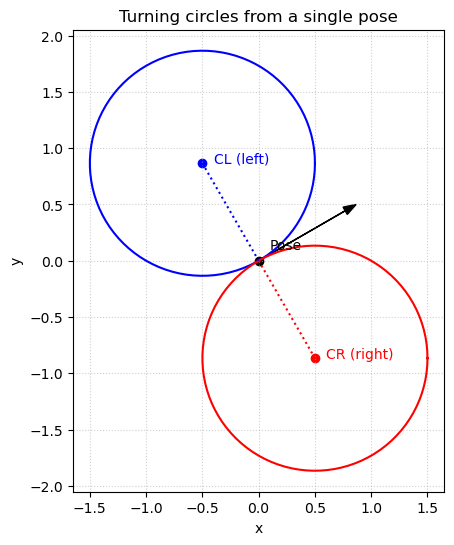

In [3]:
def turning_circles_from_pose(pose, R):
    """
    Given a pose and turning radius R, return the centers of the
    left-turn and right-turn circles.

    pose: Pose(x, y, heading)  # heading in radians
    R   : turning radius

    Returns:
        CL, CR as 2D numpy arrays
        - CL: center of left-turn circle
        - CR: center of right-turn circle
    """
    x, y, theta = pose.x, pose.y, pose.heading

    # Heading unit vector h = (cos θ, sin θ)
    h = np.array([math.cos(theta), math.sin(theta)])

    # 90° CCW and CW rotations of h
    n_left  = np.array([-h[1], h[0]])   # (-sin θ, cos θ)
    n_right = np.array([ h[1], -h[0]])  # ( sin θ, -cos θ)

    # Circle centers = position + R * normal
    CL = np.array([x, y]) + R * n_left
    CR = np.array([x, y]) + R * n_right

    return CL, CR


# --- Demo: visualize left/right circles for a single pose ---

R = 1.0
pose = Pose(x=0.0, y=0.0, heading=math.radians(30.0))

CL, CR = turning_circles_from_pose(pose, R)

print("Pose:")
print("  position:", (pose.x, pose.y))
print("  heading (deg):", math.degrees(pose.heading))
print("\nTurning circles:")
print("  Left  circle center CL:", CL)
print("  Right circle center CR:", CR)

# Distances from pose to circle centers (should both be R)
d_CL = np.linalg.norm(CL - np.array([pose.x, pose.y]))
d_CR = np.linalg.norm(CR - np.array([pose.x, pose.y]))
print("\nDistance from pose to CL (should be R):", d_CL)
print("Distance from pose to CR (should be R):", d_CR)

# --- Plotting ---
setup_plot("Turning circles from a single pose")

# Plot heading arrow from the robot pose
plot_arrow(np.array([pose.x, pose.y]), pose.heading, length=1.0, color='black')
plt.scatter(pose.x, pose.y, color='black')
plt.text(pose.x + 0.1, pose.y + 0.1, 'Pose', color='black')

# Plot the left and right circles
plot_circle(CL, R, color='blue')
plot_circle(CR, R, color='red')

# Mark circle centers
plt.scatter(CL[0], CL[1], color='blue')
plt.scatter(CR[0], CR[1], color='red')
plt.text(CL[0] + 0.1, CL[1], 'CL (left)', color='blue')
plt.text(CR[0] + 0.1, CR[1], 'CR (right)', color='red')

# Draw radii from pose to each center
plot_line(np.array([pose.x, pose.y]), CL, color='blue', style=':')
plot_line(np.array([pose.x, pose.y]), CR, color='red', style=':')

plt.show()

## **Movement Constraints**
A Dubins vehicle has two key limits:

- It **can only move forward** (no reversing).
- It can turn **left (L)** or **right (R)** with a **fixed minimum turning radius**, or move **straight (S)**.

Because of these constraints, every shortest Dubins path is made up of **three segments**, each either:
- a left-turn arc (**L**),
- a right-turn arc (**R**), or
- a straight line (**S**).

---

## **The Six Dubins Path Types**

The possible sequences of three motion segments are:

- **LSL** — Left → Straight → Left  
- **RSR** — Right → Straight → Right  
- **LSR** — Left → Straight → Right  
- **RSL** — Right → Straight → Left  
- **LRL** — Left → Right → Left  
- **RLR** — Right → Left → Right  

These fall into two higher-level categories:

### **1. CSC Paths — Curve → Straight → Curve**
First and last segments are turning arcs, connected by a straight line.

- `LSL`, `RSR`  
- `LSR`, `RSL`

### **2. CCC Paths — Curve → Curve → Curve**
All three segments are circular arcs:

- `LRL`, `RLR`

---

## **How These Paths Are Constructed**

Dubins paths arise from three geometric constructions:

1. **External Tangents**  
   Used when the first and last turns have the **same direction**  
   (`LSL`, `RSR`).

2. **Internal Tangents**  
   Used when the turns have **opposite directions**  
   (`LSR`, `RSL`).

3. **CCC Construction**  
   Used when the straight segment disappears and the solution becomes a sequence of three arcs  
   (`LRL`, `RLR`).

---

## Perpendicular Vector Helpers

When constructing CSC Dubins paths (LSL, RSR, LSR, RSL), we often need a
**perpendicular direction** to the line connecting the two turning-circle centers.

This perpendicular direction is used to determine:
- **which side** of the center–center line a tangent lies on,
- whether the tangent is consistent with a **left** or **right** turn.

In 2D, a 90° rotation is straightforward:

- A 90° **counter-clockwise (CCW)** rotation of a vector \([x, y]\) is  
  \([-y, x]\)
- A 90° **clockwise (CW)** rotation is  
  \([y, -x]\)

We encapsulate these operations in two helpers:

- `perp_ccw(v)` → returns the 90° CCW perpendicular  
- `perp_cw(v)`  → returns the 90° CW perpendicular  

These perpendicular vectors will later be used when locating tangent points for
LSL, RSR, LSR, and RSL paths.


In [4]:
def perp_ccw(v):
    """
    Return the 90° counter-clockwise (CCW) perpendicular of a 2D vector.

    Given a vector v = [x, y], the CCW perpendicular is:
        [-y, x]

    This is used when a leftward (CCW) perpendicular direction is required,
    such as identifying the correct side for tangent construction in
    left-turn paths like LSL or LSR.
    """
    return np.array([-v[1], v[0]])


def perp_cw(v):
    """
    Return the 90° clockwise (CW) perpendicular of a 2D vector.

    Given a vector v = [x, y], the CW perpendicular is:
        [y, -x]

    This is used when a rightward (CW) perpendicular direction is required,
    such as identifying the correct side for tangent construction in
    right-turn paths like RSR or RSL.
    """
    return np.array([v[1], -v[0]])


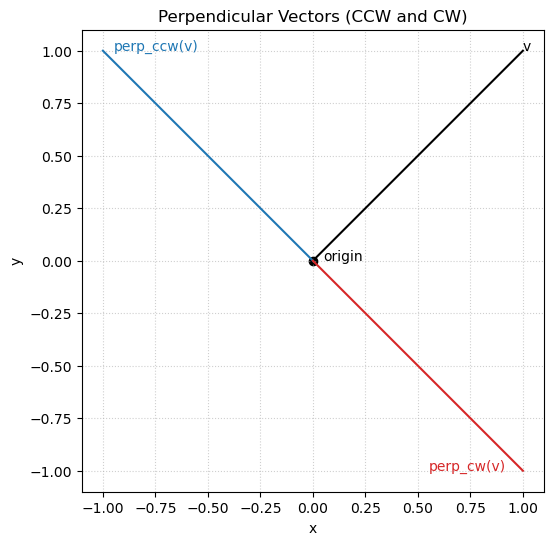

In [5]:
# Demonstration: Visualise perpendicular directions
origin = np.array([0.0, 0.0])
v = np.array([1.0, 1.0]) # Example vector

v_ccw = perp_ccw(v) # Counter-clockwise
v_cw  = perp_cw(v) # Clockwise

# TODO: add arrows for direction

setup_plot("Perpendicular Vectors (CCW and CW)")

# Original vector
plot_line(origin, origin + v, color='black')
plt.text(origin[0] + v[0], origin[1] + v[1], "v", color='black')

# CCW perpendicular
plot_line(origin, origin + v_ccw, color='tab:blue')
plt.text(origin[0] + v_ccw[0] + 0.05, origin[1] + v_ccw[1], "perp_ccw(v)", color='tab:blue')

# CW perpendicular
plot_line(origin, origin + v_cw, color='tab:red')
plt.text(origin[0] + v_cw[0] - 0.45, origin[1] + v_cw[1], "perp_cw(v)", color='tab:red')

# Origin
plt.scatter([origin[0]], [origin[1]], color='k')
plt.text(origin[0] + 0.05, origin[1], "origin", color='k')

plt.show()


## Geometry for CSC Paths

CSC paths can be solved using either **external tangents** or **internal tangents** between turning circles.

### External Tangents (**LSL** and **RSR**)

For an **LSL** path:
- Start on a **L**eft-turn circle.
- End on a **L**eft-turn circle.
- Connect them with a **S**traight segment that is tangent to both circles.

For an **RSR** path:
- Start on a **R**ight-turn circle.
- End on a **R**ight-turn circle.
- Connect them with a **S**traight tangent segment.

---

#### Key Geometric Insight

For two circles with the **same radius**, the external tangent line is:

- **perfectly parallel** to the line between the centers,  
- displaced by the radius.

##### Why are the external tangents perfectly parallel?

Here we are talking about **external tangents** between two circles of the same radius:
- one around the start pose (center `CL_s`)
- one around the goal pose (center `CL_g`)

The idea is:

1. First, compute the vector from the start circle center to the goal circle center:

   v = CL_g - CL_s

   This is the **center-line vector**.

2. Convert that to a **unit direction**:

   u = v / ||v||

   So `u` just points from `CL_s` to `CL_g` with length 1.

3. Rotate `u` by 90 degrees to get a **perpendicular direction**:
   - For an LSL path, we rotate counter-clockwise (CCW).
   - For an RSR path, we rotate clockwise (CW).

   This perpendicular direction is the direction we use to “shift” from the circle centers out to the tangent points.

4. Use that perpendicular direction to compute the tangent points:

   t1 = CL_s + R * n  
   t2 = CL_g + R * n  

   where:
   - `R` is the turning radius,
   - `n` is the 90-degree rotated (perpendicular) unit vector.

5. Now look at the vector from `t1` to `t2`:

   t2 - t1 = (CL_g + R * n) - (CL_s + R * n)
           = CL_g - CL_s
           = v

So the vector from `t1` to `t2` is **exactly the same** as the vector from `CL_s` to `CL_g`:

- same direction  
- same length  

That means the straight external tangent segment is just a **copy of the center-line vector**, shifted sideways by one radius.  
That is why the external tangent is perfectly parallel to the line between the circle centers.

In [6]:
import numpy as np

# Example data: centers and radius
CL_s = np.array([0.0, 0.0])   # start circle center
CL_g = np.array([4.0, 2.0])   # goal circle center
R    = 1.0                    # turning radius

print("Start center CL_s:", CL_s)
print("Goal  center CL_g:", CL_g)
print("Radius R:", R)
print()

# 1. Center-line vector v = CL_g - CL_s
v = CL_g - CL_s
print("-" * 10)
print("STEP 1")
print("-" * 10)
print("Center-line vector v = CL_g - CL_s")
print("v =", v)
print()

# 2. Unit direction u = v / ||v||
L = np.linalg.norm(v) # math.sqrt((x2 - x1)^2 + (y2 - y1)^2)
u = v / L
print("-" * 10)
print("STEP 2")
print("-" * 10)
print("Unit direction u = v / ||v||")
print("||v|| =", L)
print("u =", u)
print("u (deg)", math.degrees(math.atan2(u[1], u[0])))
print()

# 3. Perpendicular direction n
n = perp_ccw(u)
print("-" * 10)
print("STEP 3")
print("-" * 10)
print("Perpendicular direction n = perp_ccw(u)")
print("n =", n)
print()

# 4. Tangent points t1, t2
t1 = CL_s + R * n
t2 = CL_g + R * n
print("-" * 10)
print("STEP 4")
print("-" * 10)
print("Tangent points")
print("t1 = CL_s + R * n =", t1)
print("t2 = CL_g + R * n =", t2)
print()

# 5. Tangent vector vs center-line vector
tangent_vec = t2 - t1
print("-" * 10)
print("STEP 5")
print("-" * 10)
print("Tangent vector = t2 - t1")
print("t2 - t1 =", tangent_vec)
print("center-line v =", v)
print("Equal? = ", np.allclose(tangent_vec, v))
print()

# Compare lengths too
print("-" * 10)
print("STEP 6")
print("-" * 10)
print("Compare lengths")
len_v = np.linalg.norm(v)
len_t = np.linalg.norm(tangent_vec)
print("||v||       =", len_v)
print("||t2 - t1|| =", len_t)

Start center CL_s: [0. 0.]
Goal  center CL_g: [4. 2.]
Radius R: 1.0

----------
STEP 1
----------
Center-line vector v = CL_g - CL_s
v = [4. 2.]

----------
STEP 2
----------
Unit direction u = v / ||v||
||v|| = 4.47213595499958
u = [0.89442719 0.4472136 ]
u (deg) 26.56505117707799

----------
STEP 3
----------
Perpendicular direction n = perp_ccw(u)
n = [-0.4472136   0.89442719]

----------
STEP 4
----------
Tangent points
t1 = CL_s + R * n = [-0.4472136   0.89442719]
t2 = CL_g + R * n = [3.5527864  2.89442719]

----------
STEP 5
----------
Tangent vector = t2 - t1
t2 - t1 = [4. 2.]
center-line v = [4. 2.]
Equal? =  True

----------
STEP 6
----------
Compare lengths
||v||       = 4.47213595499958
||t2 - t1|| = 4.47213595499958


#### Constructing External Tangent Paths (LSL / RSR)

For external tangent cases (LSL and RSR), we work with the two turning circles
that correspond to the start and goal poses:

- `CL_s` = center of the start turning circle  
- `CL_g` = center of the goal turning circle  
- `R`    = common turning radius  

The straight segment `S` connects two tangent points:  
`t1` on the start circle and `t2` on the goal circle.

For circles of equal radius, we construct the external tangent using the
following steps:

##### 1. Draw the center line  
Compute the vector from the start circle center to the goal circle center:

`v = CL_g - CL_s`

This is the **center-to-center line**.  
Its length `L = ||v||` will also be the length of the straight `S` segment.

##### 2. Find a perpendicular direction  
Normalize the center-line vector:

`u = v / ||v||`

Then take a 90° perpendicular to `u`:

- **LSL:** use a CCW (counter-clockwise) perpendicular  
  (`perp_ccw(u)`)
- **RSR:** use a CW (clockwise) perpendicular  
  (`perp_cw(u)`)

This perpendicular vector `n` determines which **side** of the center-line the
external tangent lies on.

##### 3. Locate the tangent points  
Shift each circle center sideways by exactly one radius:

- `t1 = CL_s + R * n`  
- `t2 = CL_g + R * n`

This places the tangent points on the boundaries of both circles.  
The line between them will be tangent because we moved each center in a
direction perpendicular to the center-line.

##### 4. Connect the tangent points  
The straight segment of the Dubins path is simply:

`t1 → t2`

Because of the way we constructed these points, the vector:

`t2 - t1`

is **exactly equal** to the original center-line vector `v`.  
This means the tangent is:

- parallel to the center-line,  
- the same length as the center-line,  
- and simply shifted sideways by one radius.

Later, we will add the circular arcs from the start pose to `t1`, and from `t2`
to the goal pose, to complete the full LSL or RSR Dubins path.


LSL example — Step 1: define circle centers and radius
Start circle center CLs: [0. 1.]
Goal  circle center CLg: [5. 2.]
Turning radius R: 1.0


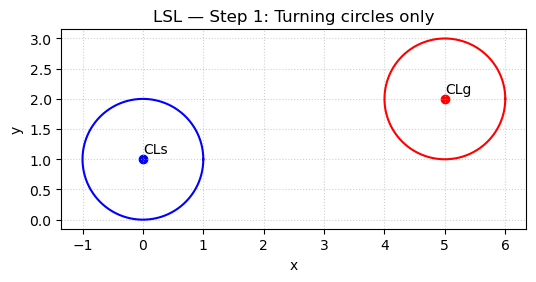


LSL example — Step 2: center-line between circle centers
Center-line vector v = CLg - CLs: [5. 1.]
Length L = ||v||: 5.0990195135927845
Unit direction u = v / L: [0.98058068 0.19611614]
Direction of u (degrees): 11.309932474020213


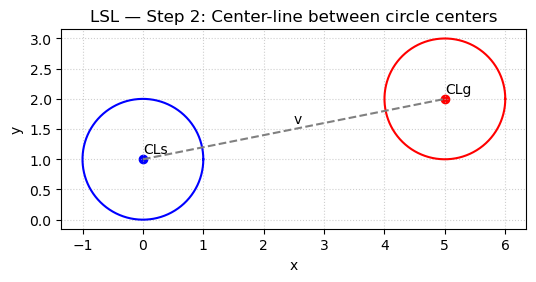


LSL example — Step 3: perpendicular direction
Perpendicular direction (perp_cw(u)): [ 0.19611614 -0.98058068]
Direction of perp_cw(u) (degrees): -78.69006752597979
Offset vector n = R * perp_cw(u): [ 0.19611614 -0.98058068]


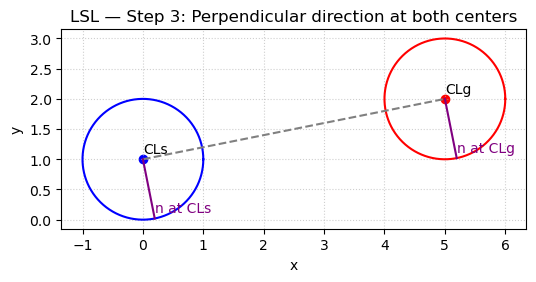


LSL example — Step 4: tangent points and external tangent
Tangent point t1 (on start circle): [0.19611614 0.01941932]
Tangent point t2 (on goal circle): [5.19611614 1.01941932]
Tangent vector t2 - t1: [5. 1.]
Center-line vector v: [5. 1.]
Are t2 - t1 and v almost equal (parallel & same length)? True


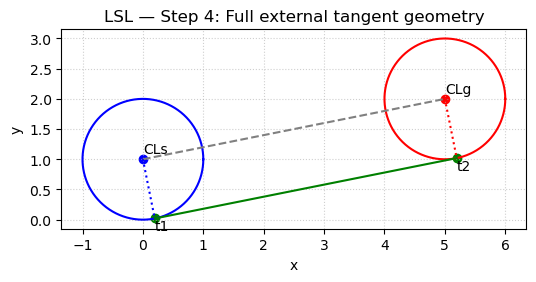

In [7]:
# ---------- LSL-style external tangent example (step-by-step) ----------

R = 1.0
CLs = np.array([0.0, 1.0])   # Start L-circle center
CLg = np.array([5.0, 2.0])   # Goal L-circle center

# STEP 1: Define the LSL setup and plot just the circles

print("LSL example — Step 1: define circle centers and radius")
print("Start circle center CLs:", CLs)
print("Goal  circle center CLg:", CLg)
print("Turning radius R:", R)

setup_plot("LSL — Step 1: Turning circles only")

# Plot the two turning circles
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Mark and label centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg')

plt.show()


# STEP 2: Compute and visualize the center-line vector v and its length L

v = CLg - CLs              # center-line vector
L = np.linalg.norm(v)      # length of v
u = v / L                  # unit direction from CLs to CLg

print("\nLSL example — Step 2: center-line between circle centers")
print("Center-line vector v = CLg - CLs:", v)
print("Length L = ||v||:", L)
print("Unit direction u = v / L:", u)
print("Direction of u (degrees):", math.degrees(math.atan2(u[1], u[0])))

setup_plot("LSL — Step 2: Center-line between circle centers")

# Plot the circles again
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Plot the centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg')

# Plot the center-line v
plot_line(CLs, CLg, color='gray', style='--')
plt.text((CLs[0] + CLg[0]) / 2.0, (CLs[1] + CLg[1]) / 2.0 + 0.1, 'v')

plt.show()


# STEP 3: Compute and visualize the perpendicular direction n

# For this geometry, perp_cw(u) gives the side we want for the external tangent.
perp_arr = perp_cw(u)
n = perp_arr * R   # scale by radius

print("\nLSL example — Step 3: perpendicular direction")
print("Perpendicular direction (perp_cw(u)):", perp_arr)
print("Direction of perp_cw(u) (degrees):", math.degrees(math.atan2(perp_arr[1], perp_arr[0])))
print("Offset vector n = R * perp_cw(u):", n)

setup_plot("LSL — Step 3: Perpendicular direction at both centers")

# Plot circles and center-line again
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')
plot_line(CLs, CLg, color='gray', style='--')

# Plot centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg')

# Visualize the perpendicular direction from both centers
plot_line(CLs, CLs + n, color='purple', style='-')
plot_line(CLg, CLg + n, color='purple', style='-')
plt.text(CLs[0] + n[0], CLs[1] + n[1] + 0.1, 'n at CLs', color='purple')
plt.text(CLg[0] + n[0], CLg[1] + n[1] + 0.1, 'n at CLg', color='purple')

plt.show()


# STEP 4: Compute tangent points t1, t2 and draw the external tangent segment S

t1 = CLs + n  # tangent point on start circle
t2 = CLg + n  # tangent point on goal circle

tangent_vec = t2 - t1

print("\nLSL example — Step 4: tangent points and external tangent")
print("Tangent point t1 (on start circle):", t1)
print("Tangent point t2 (on goal circle):", t2)
print("Tangent vector t2 - t1:", tangent_vec)
print("Center-line vector v:", v)
print("Are t2 - t1 and v almost equal (parallel & same length)?", np.allclose(tangent_vec, v))

setup_plot("LSL — Step 4: Full external tangent geometry")

# Plot circles
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Plot centers and center-line
plot_line(CLs, CLg, color='gray', style='--')
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg')

# Plot tangent points
plt.scatter(t1[0], t1[1], color='green')
plt.scatter(t2[0], t2[1], color='green')
plt.text(t1[0], t1[1] - 0.2, 't1')
plt.text(t2[0], t2[1] - 0.2, 't2')

# Plot the S segment (external tangent)
plot_line(t1, t2, color='green', style='-')

# Plot the radii to the tangent points
plot_line(CLs, t1, color='blue', style=':')
plot_line(CLg, t2, color='red', style=':')

plt.show()


RSR example — Step 1: define circle centers and radius
Start circle center CLs: [0. 1.]
Goal  circle center CLg: [ 5. -1.]
Turning radius R: 1.0


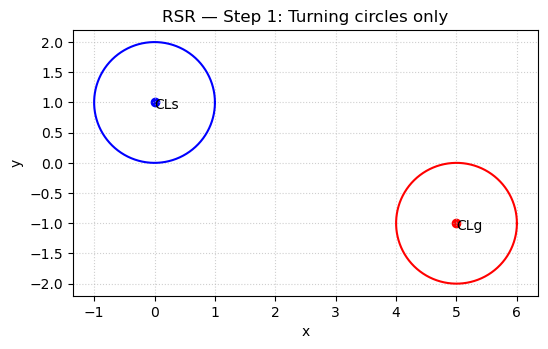


RSR example — Step 2: center-line between circle centers
Center-line vector v = CLg - CLs: [ 5. -2.]
Length L = ||v||: 5.385164807134504
Unit direction u = v / L: [ 0.92847669 -0.37139068]
Direction of u (degrees): -21.80140948635181


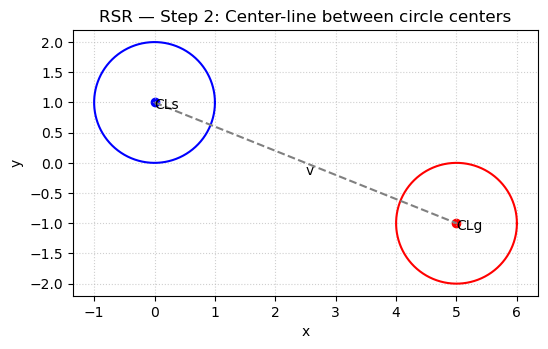


RSR example — Step 3: perpendicular direction
Perpendicular direction (perp_ccw(u)): [0.37139068 0.92847669]
Direction of perp_ccw(u) (degrees): 68.1985905136482
Offset vector n = R * perp_ccw(u): [0.37139068 0.92847669]


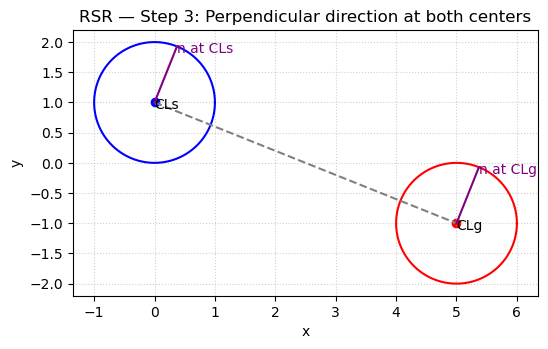


RSR example — Step 4: tangent points and external tangent
Tangent point t1 (on start circle): [0.37139068 1.92847669]
Tangent point t2 (on goal circle): [ 5.37139068 -0.07152331]
Tangent vector t2 - t1: [ 5. -2.]
Center-line vector v: [ 5. -2.]
Are t2 - t1 and v almost equal (parallel & same length)? True


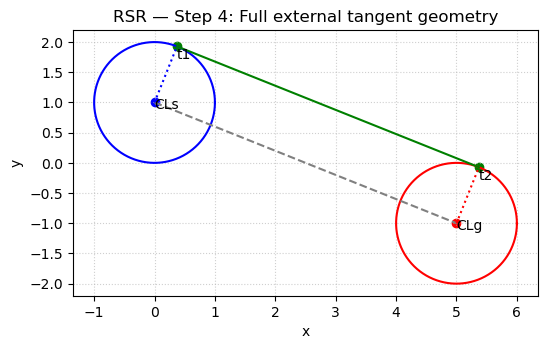

In [8]:
# ---------- RSR-style external tangent example (step-by-step) ----------

R = 1.0
CLs = np.array([0.0, 1.0])    # Start R-circle center (example)
CLg = np.array([5.0, -1.0])   # Goal R-circle center

# STEP 1: Define the RSR setup and plot just the circles

print("RSR example — Step 1: define circle centers and radius")
print("Start circle center CLs:", CLs)
print("Goal  circle center CLg:", CLg)
print("Turning radius R:", R)

setup_plot("RSR — Step 1: Turning circles only")

# Plot the two turning circles
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Mark and label centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] - 0.1, 'CLs')
plt.text(CLg[0], CLg[1] - 0.1, 'CLg')

plt.show()


# STEP 2: Compute and visualize the center-line vector v and its length L

v = CLg - CLs              # center-line vector
L = np.linalg.norm(v)      # length of v
u = v / L                  # unit direction from CLs to CLg

print("\nRSR example — Step 2: center-line between circle centers")
print("Center-line vector v = CLg - CLs:", v)
print("Length L = ||v||:", L)
print("Unit direction u = v / L:", u)
print("Direction of u (degrees):", math.degrees(math.atan2(u[1], u[0])))

setup_plot("RSR — Step 2: Center-line between circle centers")

# Plot the circles again
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Plot the centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] - 0.1, 'CLs')
plt.text(CLg[0], CLg[1] - 0.1, 'CLg')

# Plot the center-line v
plot_line(CLs, CLg, color='gray', style='--')
plt.text((CLs[0] + CLg[0]) / 2.0, (CLs[1] + CLg[1]) / 2.0 - 0.2, 'v')

plt.show()


# STEP 3: Compute and visualize the perpendicular direction n

# For this geometry, perp_ccw(u) gives the side we want for the external tangent.
perp_arr = perp_ccw(u)
n = perp_arr * R   # scale by radius

print("\nRSR example — Step 3: perpendicular direction")
print("Perpendicular direction (perp_ccw(u)):", perp_arr)
print("Direction of perp_ccw(u) (degrees):", math.degrees(math.atan2(perp_arr[1], perp_arr[0])))
print("Offset vector n = R * perp_ccw(u):", n)

setup_plot("RSR — Step 3: Perpendicular direction at both centers")

# Plot circles and center-line again
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')
plot_line(CLs, CLg, color='gray', style='--')

# Plot centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] - 0.1, 'CLs')
plt.text(CLg[0], CLg[1] - 0.1, 'CLg')

# Visualize the perpendicular direction from both centers
plot_line(CLs, CLs + n, color='purple', style='-')
plot_line(CLg, CLg + n, color='purple', style='-')
plt.text(CLs[0] + n[0], CLs[1] + n[1] - 0.1, 'n at CLs', color='purple')
plt.text(CLg[0] + n[0], CLg[1] + n[1] - 0.1, 'n at CLg', color='purple')

plt.show()


# STEP 4: Compute tangent points t1, t2 and draw the external tangent segment S

t1 = CLs + n  # tangent point on start circle
t2 = CLg + n  # tangent point on goal circle

tangent_vec = t2 - t1

print("\nRSR example — Step 4: tangent points and external tangent")
print("Tangent point t1 (on start circle):", t1)
print("Tangent point t2 (on goal circle):", t2)
print("Tangent vector t2 - t1:", tangent_vec)
print("Center-line vector v:", v)
print("Are t2 - t1 and v almost equal (parallel & same length)?", np.allclose(tangent_vec, v))

setup_plot("RSR — Step 4: Full external tangent geometry")

# Plot circles
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Plot centers and center-line
plot_line(CLs, CLg, color='gray', style='--')
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] - 0.1, 'CLs')
plt.text(CLg[0], CLg[1] - 0.1, 'CLg')

# Plot tangent points
plt.scatter(t1[0], t1[1], color='green')
plt.scatter(t2[0], t2[1], color='green')
plt.text(t1[0], t1[1] - 0.2, 't1')
plt.text(t2[0], t2[1] - 0.2, 't2')

# Plot the S segment (external tangent)
plot_line(t1, t2, color='green', style='-')

# Plot the radii to the tangent points
plot_line(CLs, t1, color='blue', style=':')
plot_line(CLg, t2, color='red', style=':')

plt.show()


### Internal Tangents (**LSR** and **RSL**)

For an **LSR** path:
- Start on a **L**eft-turn circle around the start pose.
- End on a **R**ight-turn circle around the goal pose.
- Connect them with a **S**traight segment that passes **between** the two circles.

For an **RSL** path:
- Start on a **R**ight-turn circle.
- End on a **L**eft-turn circle.
- Again, connect them with a **S**traight segment that cuts **between** the circles.

These straight segments are called **internal tangents** because they cross through the gap between the two circles, instead of running on the outside like external tangents.

---

#### Key Geometric Insight

For two circles with the **same radius**, an internal tangent:

- crosses between the circles,
- is **not parallel** to the line between their centers,
- and can be found by solving a **right triangle** whose sides involve the distance between centers and the **sum** of the radii.

Instead of just “sliding” the center-line sideways by one radius (like external tangents), we have to tilt the straight segment inward so that it touches both circles on opposite sides.

##### Why do internal tangents use a helper triangle?

Here we are talking about **internal tangents** between two equal-radius circles:

- one left-turn circle around the start pose (center `CL_s`)
- one right-turn circle around the goal pose (center `CR_g`)

The idea is:

1. First, compute the vector from the start circle center to the goal circle center:

   `v = CR_g - CL_s`

   This is the **center-line vector**, and its length

   `L = ||v||`

   is the distance between the two circle centers.

2. For an internal tangent, the straight line must touch the two circles on **opposite sides**. The perpendicular separation between those two contact points is therefore:

   `Opposite = R_start + R_goal`

   For a Dubins vehicle with equal radii, this becomes:

   `Opposite = 2R`.

3. Now imagine a **right triangle** where:

   - the hypotenuse is the center distance `L`,
   - the opposite side is `Opposite = R_start + R_goal`,
   - and the remaining side (the adjacent side) has length `p`, which will end up being the length of the straight `S` segment between the two tangent points.

   By the Pythagorean theorem:

   `p^2 + Opposite^2 = L^2`

   so

   `p = sqrt(L^2 - Opposite^2)`.

4. The angle between the center-line and the internal tangent is a right-triangle angle `beta` that satisfies:

   `sin(beta) = Opposite / L`

   so

   `beta = arcsin(Opposite / L)`.

   This angle tells us **how much we must rotate** the center-line direction to aim the internal tangent between the circles.

5. Once we know `p` (the length of the straight segment) and `beta` (the tilt relative to the center-line), we can:

   - rotate the center-line direction by `+beta` or `-beta` (depending on LSR vs RSL), and
   - use that rotated direction as the direction of the internal `S` segment.

This is why internal tangents require a helper triangle: we are not just shifting the center-line sideways, we are tilting a new line so that it grazes both circles on opposite sides.

---

#### Constructing Internal Tangent Paths (LSR / RSL)

For internal tangent cases (LSR and RSL), we again work with the two turning circles that correspond to the start and goal poses:

- `CL_s` = center of the start turning circle  
- `CR_g` = center of the goal turning circle  
- `R_start`, `R_goal` = turning radii (often both equal to `R` in Dubins problems)  

The straight segment `S` connects two tangent points:

- `t1` on the start circle  
- `t2` on the goal circle  

For circles of equal radius, we construct the internal tangent using the following steps.

##### 1. Draw the center line

Compute the vector from the start circle center to the goal circle center:

`v = CR_g - CL_s`

This is the **center-to-center line**.  
Its length

`L = ||v||`

is the distance between the circle centers and will be the **hypotenuse** of our helper triangle.

##### 2. Build the helper triangle

Set the “opposite” side of the triangle to be the sum of the radii:

`Opposite = R_start + R_goal`

For equal radii, this simplifies to `Opposite = 2R`.

The right triangle has:
- Hypotenuse: `L`  
- Opposite side: `Opposite`  
- Adjacent side: `p` (the length of the straight `S` segment between tangent points)

Use Pythagoras to solve for `p`:

`p = sqrt(L^2 - Opposite^2)`

Then compute the tilt angle `beta` between the center-line and the internal tangent:

`beta = arcsin(Opposite / L)`

This gives you both **how long** the internal straight segment is and **how far** it must be rotated relative to the center-line.

##### 3. Find a direction for the S segment

Normalize the center-line direction:

`u = v / L`

This unit vector `u` points from the start circle center toward the goal circle center.

Now rotate `u` by the angle `beta`:

- For **LSR**, rotate `u` by `+beta`.
- For **RSL**, rotate `u` by `-beta`.

The result is a new unit vector `d`, which is the **direction of the internal tangent line**.

##### 4. Locate the tangent points

A tangent touches a circle at exactly one point where the radius is **perpendicular** to the tangent line.

Using the direction `d`, we can form a perpendicular direction to find the tangent points:

- For a **left-turn** circle, use a **CCW perpendicular** to `d`.
- For a **right-turn** circle, use a **CW perpendicular** to `d`.

Then we shift each circle center by one radius along the correct perpendicular direction:

- `t1` on the start circle is found by moving from `CL_s` by `R_start` along the appropriate perpendicular.
- `t2` on the goal circle is found by moving from `CR_g` by `R_goal` along the opposite perpendicular.

This ensures that the line segment from `t1` to `t2` is tangent to both circles.

##### 5. Connect the tangent points

The straight Dubins segment `S` is just the line from `t1` to `t2`:

`t1 → t2`

By construction, this segment:

- has length `p`,  
- is aimed at an angle `beta` relative to the center-line,  
- and touches both circles exactly once on opposite sides.

Later, we will add the circular arcs from the start pose to `t1`, and from `t2` to the goal pose, to complete the full LSR or RSL Dubins path.

---

**Note on normalization:**

Many Dubins solvers internally scale all distances by the turning radius so that the effective radius becomes `R = 1` during the math, and then scale the final path length back by `R`. In this explanation, we keep the radii `R_start` and `R_goal` explicit so that the geometry of internal tangents remains clear.

LSR example — Step 1: define circle centers and radius
Start L-circle center CLs: [1. 1.]
Goal  R-circle center CRg: [4. 2.]
Turning radius R: 1.0


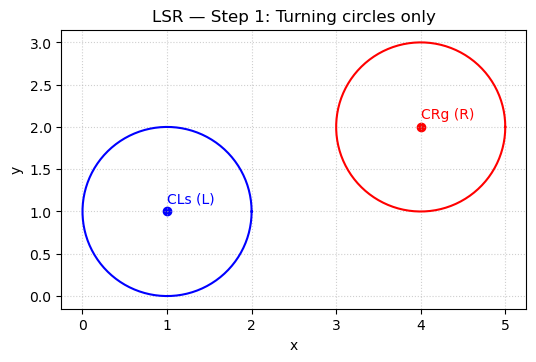


LSR example — Step 2: center-line between circle centers
Center-line vector v = CRg - CLs: [3. 1.]
Length L = ||v||: 3.1622776601683795
Unit direction u = v / L: [0.9486833  0.31622777]
Direction of u (degrees): 18.43494882292201


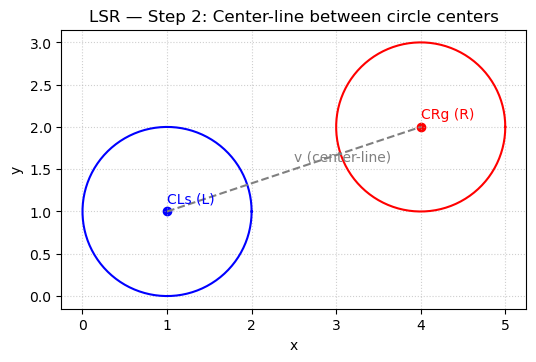


LSR example — Step 3: helper triangle and tilt angle beta
Opposite (R_start + R_goal) = 2.0
Adjacent p_len = sqrt(L^2 - Opposite^2): 2.4494897427831783
beta = asin(Opposite / L): 0.684719203002283 rad  = 39.23152048359226 deg
Direction w (u rotated by +beta): [0.53484692 0.84494897]
Direction of w (degrees): 57.66646930651426


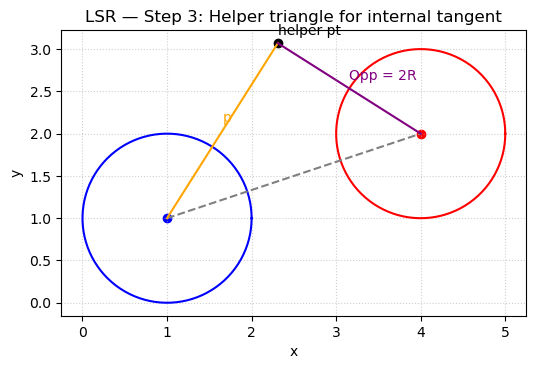


LSR example — Step 4: visualize directions u, w and angle beta


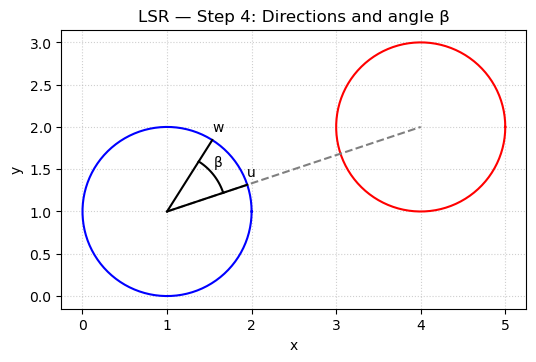


LSR example — Step 5: tangent points and internal tangent
Tangent point t1 (on start L-circle): [1.84494897 0.46515308]
Tangent point t2 (on goal  R-circle): [3.15505103 2.53484692]
Tangent vector t2 - t1: [1.31010205 2.06969385]
Length of tangent segment |t2 - t1| (should be ~p_len): 2.449489742783178


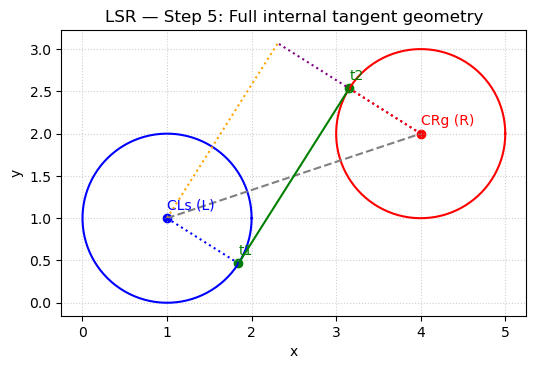

In [9]:
# ---------- LSR-style internal tangent example (step-by-step) ----------

R = 1.0
CLs = np.array([1.0, 1.0])   # Start L-circle center
CRg = np.array([4.0, 2.0])   # Goal R-circle center

# STEP 1: Define the LSR setup and plot just the circles

print("LSR example — Step 1: define circle centers and radius")
print("Start L-circle center CLs:", CLs)
print("Goal  R-circle center CRg:", CRg)
print("Turning radius R:", R)

setup_plot("LSR — Step 1: Turning circles only")

# Plot the two turning circles
plot_circle(CLs, R, color='blue')
plot_circle(CRg, R, color='red')

# Mark and label centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CRg[0], CRg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
plt.text(CRg[0], CRg[1] + 0.1, 'CRg (R)', color='red')

plt.show()


# STEP 2: Compute and visualize the center-line vector v and its length L

v = CRg - CLs              # center-line vector
L = np.linalg.norm(v)      # length of v

print("\nLSR example — Step 2: center-line between circle centers")
print("Center-line vector v = CRg - CLs:", v)
print("Length L = ||v||:", L)

if L <= 2 * R:
    print("Circles are too close for an internal tangent (L <= 2R).")
else:
    u = v / L                  # unit direction from CLs to CRg
    theta_u = math.atan2(u[1], u[0])

    print("Unit direction u = v / L:", u)
    print("Direction of u (degrees):", math.degrees(theta_u))

    setup_plot("LSR — Step 2: Center-line between circle centers")

    # Plot the circles again
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')

    # Plot the centers
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CRg[0], CRg[1], color='red')
    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
    plt.text(CRg[0], CRg[1] + 0.1, 'CRg (R)', color='red')

    # Plot the center-line v
    plot_line(CLs, CRg, color='gray', style='--')
    mid = 0.5 * (CLs + CRg)
    plt.text(mid[0], mid[1] + 0.1, 'v (center-line)', color='gray')

    plt.show()


    # STEP 3: Build the helper triangle (Opposite, p, beta) and visualize it

    Opposite = 2.0 * R   # R_start + R_goal for equal radii
    p_len = math.sqrt(L * L - Opposite * Opposite)  # adjacent side
    beta = math.asin(Opposite / L)                  # angle between v and S

    print("\nLSR example — Step 3: helper triangle and tilt angle beta")
    print("Opposite (R_start + R_goal) =", Opposite)
    print("Adjacent p_len = sqrt(L^2 - Opposite^2):", p_len)
    print("beta = asin(Opposite / L):", beta, "rad  =", math.degrees(beta), "deg")

    # Direction of S: rotate u by +beta (for LSR)
    w = np.array([
        u[0] * math.cos(beta) - u[1] * math.sin(beta),
        u[0] * math.sin(beta) + u[1] * math.cos(beta)
    ])
    theta_w = math.atan2(w[1], w[0])

    print("Direction w (u rotated by +beta):", w)
    print("Direction of w (degrees):", math.degrees(theta_w))

    # Helper triangle "corner" from CLs: length p_len along w
    helper_pt = CLs + w * p_len

    setup_plot("LSR — Step 3: Helper triangle for internal tangent")

    # Circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')

    # Center-line (hypotenuse L)
    plot_line(CLs, CRg, color='gray', style='--')

    # Helper triangle sides:
    #  CLs -> helper_pt : adjacent side (p)
    #  CRg -> helper_pt : opposite side (2R)
    plot_line(CLs, helper_pt, color='orange', style='-')
    plot_line(CRg, helper_pt, color='purple', style='-')

    # Mark points
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CRg[0], CRg[1], color='red')
    plt.scatter(helper_pt[0], helper_pt[1], color='black')

    # Labels
    plt.text(helper_pt[0], helper_pt[1] + 0.1, 'helper pt', color='black')
    plt.text(0.5 * (CLs[0] + helper_pt[0]),
             0.5 * (CLs[1] + helper_pt[1]) + 0.1,
             'p', color='orange')
    plt.text(0.5 * (CRg[0] + helper_pt[0]),
             0.5 * (CRg[1] + helper_pt[1]) + 0.1,
             'Opp = 2R', color='purple')

    plt.show()


    # STEP 4: Directions u and w, and angle beta between them

    print("\nLSR example — Step 4: visualize directions u, w and angle beta")

    setup_plot("LSR — Step 4: Directions and angle β")

    # Circles + center-line for context
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')
    plot_line(CLs, CRg, color='gray', style='--')

    # Draw u and w from CLs
    u_len = 1.0
    w_len = 1.0
    u_tip = CLs + u_len * u
    w_tip = CLs + w_len * w

    plot_line(CLs, u_tip, color='black', style='-')
    plot_line(CLs, w_tip, color='black', style='-')
    plt.text(u_tip[0], u_tip[1] + 0.1, 'u', color='black')
    plt.text(w_tip[0], w_tip[1] + 0.1, 'w', color='black')

    # Draw small arc for beta between u and w at CLs
    arc_radius = 0.7
    theta_start = theta_u
    theta_end = theta_u + beta
    arc_thetas = np.linspace(theta_start, theta_end, 40)
    arc_pts = np.column_stack([
        CLs[0] + arc_radius * np.cos(arc_thetas),
        CLs[1] + arc_radius * np.sin(arc_thetas),
    ])
    plt.plot(arc_pts[:, 0], arc_pts[:, 1], color='black')
    mid_arc = arc_pts[len(arc_pts) // 2]
    plt.text(mid_arc[0], mid_arc[1] + 0.1, r'β', color='black')

    plt.show()


    # STEP 5: Compute tangent points t1, t2 and draw the internal tangent segment S

    # For LSR:
    #  - Start circle is Left-turn  -> tangent radius is CW of w  -> perp_cw(w)
    #  - Goal  circle is Right-turn -> tangent radius is CCW of w -> perp_ccw(w)
    radius_start = perp_cw(w) * R
    radius_goal  = perp_ccw(w) * R

    t1 = CLs + radius_start
    t2 = CRg + radius_goal

    tangent_vec = t2 - t1

    print("\nLSR example — Step 5: tangent points and internal tangent")
    print("Tangent point t1 (on start L-circle):", t1)
    print("Tangent point t2 (on goal  R-circle):", t2)
    print("Tangent vector t2 - t1:", tangent_vec)
    print("Length of tangent segment |t2 - t1| (should be ~p_len):",
          np.linalg.norm(tangent_vec))

    setup_plot("LSR — Step 5: Full internal tangent geometry")

    # Plot circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')

    # Plot centers and center-line
    plot_line(CLs, CRg, color='gray', style='--')
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CRg[0], CRg[1], color='red')
    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
    plt.text(CRg[0], CRg[1] + 0.1, 'CRg (R)', color='red')

    # Plot helper triangle lightly (for context)
    plot_line(CLs, helper_pt, color='orange', style=':')
    plot_line(CRg, helper_pt, color='purple', style=':')

    # Plot tangent points
    plt.scatter(t1[0], t1[1], color='green')
    plt.scatter(t2[0], t2[1], color='green')
    plt.text(t1[0], t1[1] + 0.1, 't1', color='green')
    plt.text(t2[0], t2[1] + 0.1, 't2', color='green')

    # Plot the S segment (internal tangent)
    plot_line(t1, t2, color='green', style='-')

    # Plot the radii to the tangent points
    plot_line(CLs, t1, color='blue', style=':')
    plot_line(CRg, t2, color='red', style=':')

    plt.show()


RSL example — Step 1: define circle centers and radius
Start R-circle center CLs: [2. 1.]
Goal  L-circle center CRg: [ 4. -2.]
Turning radius R: 1.0


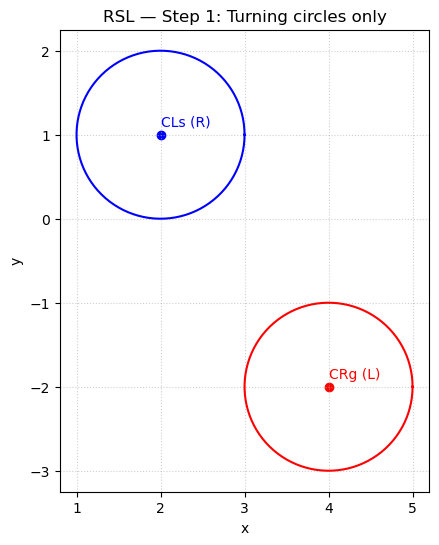


RSL example — Step 2: center-line between circle centers
Center-line vector v = CRg - CLs: [ 2. -3.]
Length L = ||v||: 3.605551275463989
Unit direction u = v / L: [ 0.5547002  -0.83205029]
Direction of u (degrees): -56.309932474020215


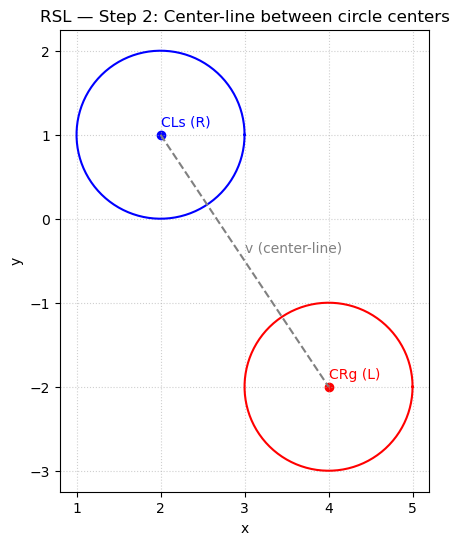


RSL example — Step 3: helper triangle and tilt angle beta
Opposite (R_start + R_goal) = 2.0
Adjacent p_len = sqrt(L^2 - Opposite^2): 2.9999999999999996
beta = asin(Opposite / L): 0.5880026035475676 rad  = 33.69006752597979 deg
Direction w (u rotated by -beta): [-5.55111512e-17 -1.00000000e+00]
Direction of w (degrees): -90.00000000000001


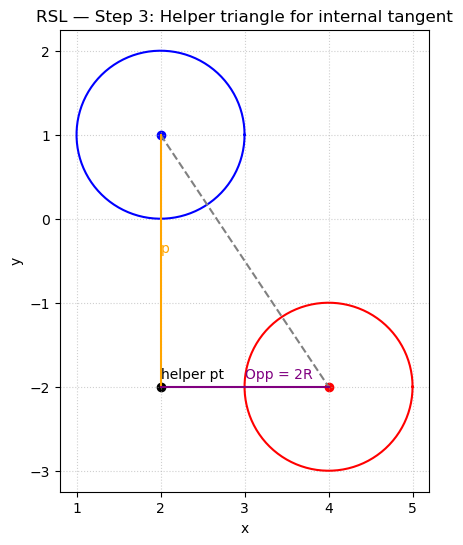


RSL example — Step 4: visualize directions u, w and angle beta


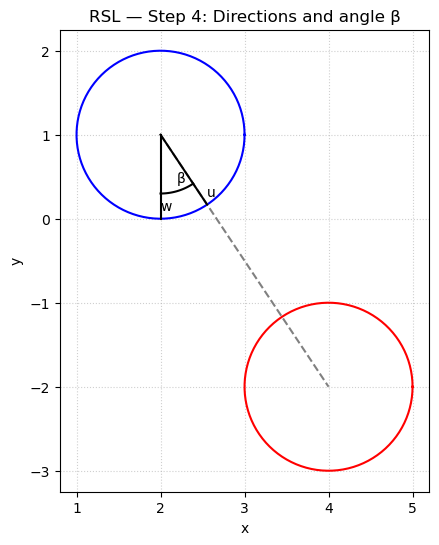


RSL example — Step 5: tangent points and internal tangent
Tangent point t1 (on start R-circle): [3. 1.]
Tangent point t2 (on goal  L-circle): [ 3. -2.]
Tangent vector t2 - t1: [ 0. -3.]
Length of tangent segment |t2 - t1| (should be ~p_len): 3.0


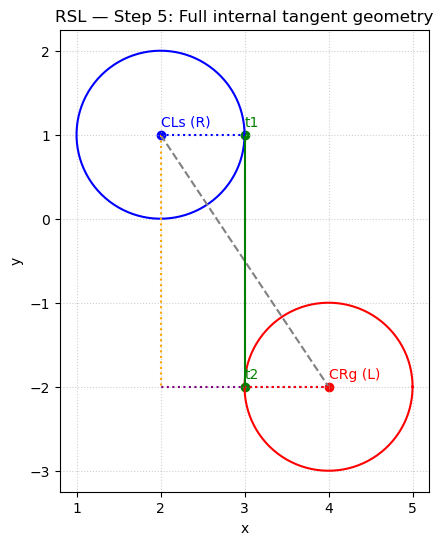

In [10]:
# ---------- RSL-style internal tangent example (step-by-step) ----------

R = 1.0
CLs = np.array([2.0, 1.0])    # Start R-circle center
CRg = np.array([4.0, -2.0])   # Goal L-circle center

# STEP 1: Define the RSL setup and plot just the circles

print("RSL example — Step 1: define circle centers and radius")
print("Start R-circle center CLs:", CLs)
print("Goal  L-circle center CRg:", CRg)
print("Turning radius R:", R)

setup_plot("RSL — Step 1: Turning circles only")

# Plot the two turning circles
plot_circle(CLs, R, color='blue')
plot_circle(CRg, R, color='red')

# Mark and label centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CRg[0], CRg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs (R)', color='blue')
plt.text(CRg[0], CRg[1] + 0.1, 'CRg (L)', color='red')

plt.show()


# STEP 2: Compute and visualize the center-line vector v and its length L

v = CRg - CLs              # center-line vector
L = np.linalg.norm(v)      # length of v

print("\nRSL example — Step 2: center-line between circle centers")
print("Center-line vector v = CRg - CLs:", v)
print("Length L = ||v||:", L)

if L <= 2 * R:
    print("Circles are too close for an internal tangent (L <= 2R).")
else:
    u = v / L                  # unit direction from CLs to CRg
    theta_u = math.atan2(u[1], u[0])

    print("Unit direction u = v / L:", u)
    print("Direction of u (degrees):", math.degrees(theta_u))

    setup_plot("RSL — Step 2: Center-line between circle centers")

    # Plot the circles again
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')

    # Plot the centers
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CRg[0], CRg[1], color='red')
    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (R)', color='blue')
    plt.text(CRg[0], CRg[1] + 0.1, 'CRg (L)', color='red')

    # Plot the center-line v
    plot_line(CLs, CRg, color='gray', style='--')
    mid = 0.5 * (CLs + CRg)
    plt.text(mid[0], mid[1] + 0.1, 'v (center-line)', color='gray')

    plt.show()


    # STEP 3: Build the helper triangle (Opposite, p, beta) and visualize it

    Opposite = 2.0 * R   # R_start + R_goal for equal radii
    p_len = math.sqrt(L * L - Opposite * Opposite)  # adjacent side
    beta = math.asin(Opposite / L)                  # angle between v and S

    print("\nRSL example — Step 3: helper triangle and tilt angle beta")
    print("Opposite (R_start + R_goal) =", Opposite)
    print("Adjacent p_len = sqrt(L^2 - Opposite^2):", p_len)
    print("beta = asin(Opposite / L):", beta, "rad  =", math.degrees(beta), "deg")

    # Direction of S: rotate u by -beta (for RSL)
    w = np.array([
        u[0] * math.cos(-beta) - u[1] * math.sin(-beta),
        u[0] * math.sin(-beta) + u[1] * math.cos(-beta)
    ])
    theta_w = math.atan2(w[1], w[0])

    print("Direction w (u rotated by -beta):", w)
    print("Direction of w (degrees):", math.degrees(theta_w))

    # Helper triangle "corner" from CLs: length p_len along w
    helper_pt = CLs + w * p_len

    setup_plot("RSL — Step 3: Helper triangle for internal tangent")

    # Circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')

    # Center-line (hypotenuse L)
    plot_line(CLs, CRg, color='gray', style='--')

    # Helper triangle sides:
    #  CLs -> helper_pt : adjacent side (p)
    #  CRg -> helper_pt : opposite side (2R)
    plot_line(CLs, helper_pt, color='orange', style='-')
    plot_line(CRg, helper_pt, color='purple', style='-')

    # Mark points
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CRg[0], CRg[1], color='red')
    plt.scatter(helper_pt[0], helper_pt[1], color='black')

    # Labels
    plt.text(helper_pt[0], helper_pt[1] + 0.1, 'helper pt', color='black')
    plt.text(0.5 * (CLs[0] + helper_pt[0]),
             0.5 * (CLs[1] + helper_pt[1]) + 0.1,
             'p', color='orange')
    plt.text(0.5 * (CRg[0] + helper_pt[0]),
             0.5 * (CRg[1] + helper_pt[1]) + 0.1,
             'Opp = 2R', color='purple')

    plt.show()


    # STEP 4: Directions u and w, and angle beta between them

    print("\nRSL example — Step 4: visualize directions u, w and angle beta")

    setup_plot("RSL — Step 4: Directions and angle β")

    # Circles + center-line for context
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')
    plot_line(CLs, CRg, color='gray', style='--')

    # Draw u and w from CLs
    u_len = 1.0
    w_len = 1.0
    u_tip = CLs + u_len * u
    w_tip = CLs + w_len * w

    plot_line(CLs, u_tip, color='black', style='-')
    plot_line(CLs, w_tip, color='black', style='-')
    plt.text(u_tip[0], u_tip[1] + 0.1, 'u', color='black')
    plt.text(w_tip[0], w_tip[1] + 0.1, 'w', color='black')

    # Draw small arc for beta between u and w at CLs (u → w is a -beta rotation)
    arc_radius = 0.7
    theta_start = theta_u
    theta_end = theta_u - beta
    arc_thetas = np.linspace(theta_start, theta_end, 40)
    arc_pts = np.column_stack([
        CLs[0] + arc_radius * np.cos(arc_thetas),
        CLs[1] + arc_radius * np.sin(arc_thetas),
    ])
    plt.plot(arc_pts[:, 0], arc_pts[:, 1], color='black')
    mid_arc = arc_pts[len(arc_pts) // 2]
    plt.text(mid_arc[0], mid_arc[1] + 0.1, r'β', color='black')

    plt.show()


    # STEP 5: Compute tangent points t1, t2 and draw the internal tangent segment S

    # For RSL:
    #  - Start circle is Right-turn -> tangent radius is CCW of w -> perp_ccw(w)
    #  - Goal  circle is Left-turn  -> tangent radius is CW of w  -> perp_cw(w)
    radius_start = perp_ccw(w) * R
    radius_goal  = perp_cw(w) * R

    t1 = CLs + radius_start
    t2 = CRg + radius_goal

    tangent_vec = t2 - t1

    print("\nRSL example — Step 5: tangent points and internal tangent")
    print("Tangent point t1 (on start R-circle):", t1)
    print("Tangent point t2 (on goal  L-circle):", t2)
    print("Tangent vector t2 - t1:", tangent_vec)
    print("Length of tangent segment |t2 - t1| (should be ~p_len):",
          np.linalg.norm(tangent_vec))

    setup_plot("RSL — Step 5: Full internal tangent geometry")

    # Plot circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CRg, R, color='red')

    # Plot centers and center-line
    plot_line(CLs, CRg, color='gray', style='--')
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CRg[0], CRg[1], color='red')
    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (R)', color='blue')
    plt.text(CRg[0], CRg[1] + 0.1, 'CRg (L)', color='red')

    # Plot helper triangle lightly (for context)
    plot_line(CLs, helper_pt, color='orange', style=':')
    plot_line(CRg, helper_pt, color='purple', style=':')

    # Plot tangent points
    plt.scatter(t1[0], t1[1], color='green')
    plt.scatter(t2[0], t2[1], color='green')
    plt.text(t1[0], t1[1] + 0.1, 't1', color='green')
    plt.text(t2[0], t2[1] + 0.1, 't2', color='green')

    # Plot the S segment (internal tangent)
    plot_line(t1, t2, color='green', style='-')

    # Plot the radii to the tangent points
    plot_line(CLs, t1, color='blue', style=':')
    plot_line(CRg, t2, color='red', style=':')

    plt.show()


## Geometry for CCC Paths

CCC paths (LRL and RLR) are the Dubins cases where **no straight segment exists**.  
Instead, the path is composed of **three circular arcs**:

- **LRL** = Left arc → Right arc → Left arc  
- **RLR** = Right arc → Left arc → Right arc

These occur when the start and goal headings require a “wrap‑around” maneuver tighter than any external or internal tangent can provide. The middle arc acts as a *bridge* between the first and final turning circles.

---

### 1. Understanding the Geometry

Let:

- `CL_s` = center of the start turning circle  
- `CL_g` = center of the goal turning circle  
- Both have radius `R`

For an LRL or RLR path, we need to introduce a **middle turning circle** (`CM`) whose radius is also `R`.

The goal:  
Find a point `CM` such that:

```
distance(CL_s, CM) = 2R
distance(CL_g, CM) = 2R
```

Why 2R?

- The middle circle must be **externally tangent** to both start and goal circles.
- For two radius‑R circles to touch externally, the center‑to‑center distance must be `R + R = 2R`.

Thus, `CM` must lie at the **intersection of two circles**:

1. Circle with center `CL_s` and radius `2R`
2. Circle with center `CL_g` and radius `2R`

This intersection produces:
- **Two possible middle centers** (upper and lower)
- Each one corresponds to one of the CCC cases (LRL or RLR)

---

### 2. Circle–Circle Intersection Formula

Given two circles:

- Center `c1`, radius `r1`
- Center `c2`, radius `r2`

The distance between centers is:

```
d = ||c2 - c1||
```

The intersection exists only if:

```
|r1 - r2| ≤ d ≤ r1 + r2
```

The formula:

```
a = (r1² - r2² + d²) / (2d)
h = sqrt(r1² - a²)
```

Where:

- `a` is the distance from `c1` to the midpoint of the chord along the line between centers
- `h` is half the chord height, perpendicular to the line between centers

Intersection points:

```
p = c1 + a * ( (c2 - c1) / d )
n = a 90° rotation of the unit vector (c2 - c1) / d

solutions:
    p + h*n
    p - h*n
```

These are the two possible `CM` locations.

---

### 3. Choosing LRL vs RLR

Once we compute the two intersection candidates:

- One corresponds to **LRL**
- The other corresponds to **RLR**

Which one is which?

It depends on:
- The initial turning direction at the start,
- The direction of the middle arc required to connect to the goal turning direction.

There is no ambiguity inside a Dubins solver; the solver evaluates both and picks the shortest valid one.

---

### 4. After Finding CM

Once we have `CM`:

- We know where the middle turning circle must sit.
- We compute the angles for the three arcs:
  - from start heading → tangent point on start circle → middle circle
  - middle circle arc angle
  - middle circle → tangent point → final heading

This process is analytical and ensures continuity of curvature.

---

### 5. When CCC Paths Occur

CCC paths appear when:
- The configuration requires a very sharp reorientation,
- And no tangent line (external or internal) fits between the start and goal circles.

They are the “tightest” possible Dubins maneuvers.

---

### Summary

CCC paths rely on constructing a **third circle** (`CM`) tangent to both the start and goal turning circles.  
The construction uses classical circle‑circle intersection geometry:

- Compute the two intersection points of radius‑2R circles around start and goal centers.
- Each intersection yields a candidate `CM`.
- One solution corresponds to **LRL** and the other to **RLR**.

This intersection is the geometric key that makes CCC paths possible.


In [11]:
def circle_intersections(c1, r1, c2, r2):
    """
    Compute the intersection points of two circles in 2D (if they exist).

    Circles:
        - Circle 1: center c1 (2D numpy array), radius r1
        - Circle 2: center c2 (2D numpy array), radius r2

    Returns:
        - []           : no intersection (separate, nested, or degenerate)
        - [p]          : exactly one intersection (tangent circles)
        - [p1, p2]     : two intersection points

    Geometry outline:
        1) Let v = c2 - c1 and d = ||v|| be the center-to-center vector and distance.
        2) Reject if:
           - d ≈ 0      (same center; infinite or no intersections)
           - d > r1+r2  (too far apart)
           - d < |r1-r2| (one circle completely inside the other without touching)
        3) Otherwise, the circles intersect in 1 or 2 points.
           - Along the line from c1 to c2, the chord of intersection has its midpoint
             at distance a from c1:
                 a = (r1^2 - r2^2 + d^2) / (2d)
           - The half-chord length (perpendicular offset) is:
                 h^2 = r1^2 - a^2
           - The midpoint p on the center line is:
                 p = c1 + a * (v / d)
           - A perpendicular unit vector n points from p to both intersection points.
             Using a CCW perpendicular: n = perp_ccw(v / d)
           - The intersection points are:
                 p + h * n,  p - h * n
    """
    # Vector between circle centers: from c1 to c2
    v = c2 - c1

    # Center distance (||v||)
    d = np.linalg.norm(v)

    # Quick rejection / degeneracy tests:
    # - d ~ 0: same center (degenerate)
    # - d > r1 + r2: centers too far apart (no intersection)
    # - d < |r1 - r2|: one circle lies completely inside the other
    if d < 1e-12 or d > r1 + r2 + 1e-12 or d < abs(r1 - r2) - 1e-12:
        # print("No intersection: d =", d, "r1 =", r1, "r2 =", r2)
        return []

    # Distance from c1 along the center line to the chord midpoint:
    # a = (r1^2 - r2^2 + d^2) / (2d)
    a = (r1 * r1 - r2 * r2 + d * d) / (2.0 * d)

    # Squared half-chord length (perpendicular offset):
    # h^2 = r1^2 - a^2
    h2 = r1 * r1 - a * a

    # Numerical guard: clamp tiny negatives to zero
    if h2 < 0:
        h2 = 0.0
    h = math.sqrt(h2)

    # Unit vector from c1 to c2
    u = v / d

    # Base point p on the line of centers (midpoint of the chord)
    p = c1 + a * u

    # A unit normal to the center line (rotate u by +90°)
    n = perp_ccw(u)

    # If h == 0, the circles are tangent: exactly one intersection at p
    if h == 0.0:
        return [p]

    # Otherwise, two intersection points symmetric about the center line
    return [p + h * n, p - h * n]


LRL example — Step 1: define circle centers and radius
Start L-circle center CLs: [1. 0.]
Goal  L-circle center CLg: [2. 3.]
Turning radius R: 1.0
Helper circle radius R_helper = 2R: 2.0


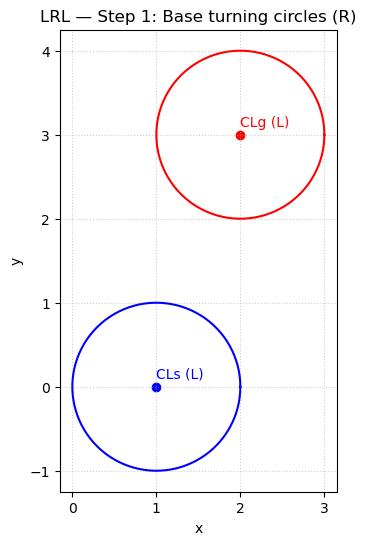


LRL example — Step 2: add helper circles of radius 2R
Center-line vector v = CLg - CLs: [1. 3.]
Center distance d = ||v||: 3.1622776601683795


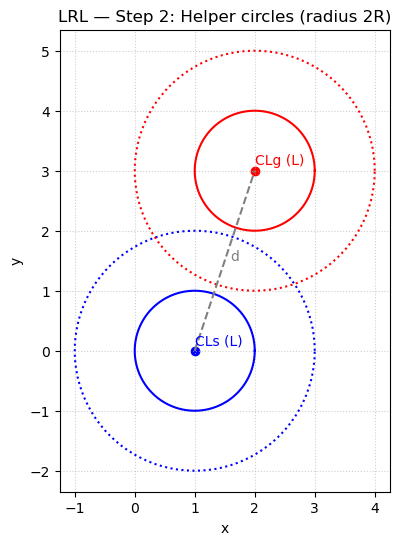


LRL example — Step 3: find intersections of helper circles
Number of intersections found: 2
Intersection 0: CM = [0.338105   1.88729833], |CLs - CM| = 2.0000, |CLg - CM| = 2.0000
Intersection 1: CM = [2.661895   1.11270167], |CLs - CM| = 2.0000, |CLg - CM| = 2.0000


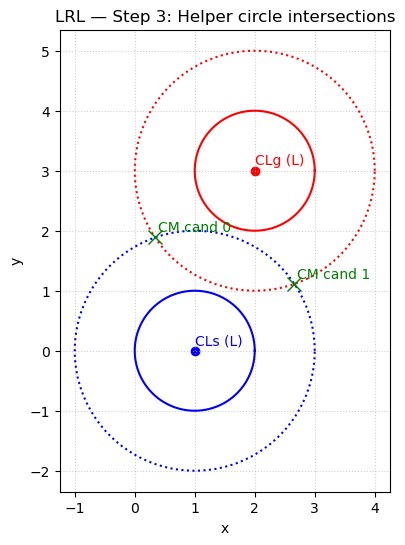


LRL example — Step 4: choose CM for middle circle
Chosen CM (for LRL): [0.338105   1.88729833]
|CLs - CM| should be ≈ 2R: 1.9999999999999998
|CLg - CM| should be ≈ 2R: 1.9999999999999998


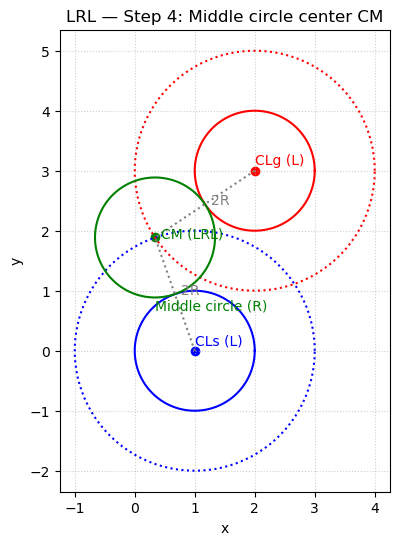

In [12]:
# ---------- LRL-style CCC example (step-by-step) ----------

R = 1.0
CLs = np.array([1.0, 0.0])   # Start L-circle center
CLg = np.array([2.0, 3.0])   # Goal  L-circle center
R_helper = 2.0 * R           # Helper circles have radius 2R

# STEP 1: Define the LRL setup and plot the base turning circles

print("LRL example — Step 1: define circle centers and radius")
print("Start L-circle center CLs:", CLs)
print("Goal  L-circle center CLg:", CLg)
print("Turning radius R:", R)
print("Helper circle radius R_helper = 2R:", R_helper)

setup_plot("LRL — Step 1: Base turning circles (R)")

# Plot the two base turning circles (R)
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Mark and label centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg (L)', color='red')

plt.show()


# STEP 2: Add helper circles of radius 2R around CLs and CLg

print("\nLRL example — Step 2: add helper circles of radius 2R")

# Center-line for context
v = CLg - CLs
d = np.linalg.norm(v)
print("Center-line vector v = CLg - CLs:", v)
print("Center distance d = ||v||:", d)

setup_plot("LRL — Step 2: Helper circles (radius 2R)")

# Base circles (R)
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Helper circles (2R)
plot_circle(CLs, R_helper, color='blue', style=':')
plot_circle(CLg, R_helper, color='red', style=':')

# Centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg (L)', color='red')

# Center-line for visualization
plot_line(CLs, CLg, color='gray', style='--')
mid = 0.5 * (CLs + CLg)
plt.text(mid[0] + 0.1, mid[1], 'd', color='gray')

plt.show()


# STEP 3: Find the intersection points of the helper circles

print("\nLRL example — Step 3: find intersections of helper circles")

intersections = circle_intersections(CLs, R_helper, CLg, R_helper)

if not intersections:
    print("No CCC solution: helper circles do not intersect.")
else:
    print("Number of intersections found:", len(intersections))
    for i, CM in enumerate(intersections):
        print(f"Intersection {i}: CM = {CM}, "
              f"|CLs - CM| = {np.linalg.norm(CM - CLs):.4f}, "
              f"|CLg - CM| = {np.linalg.norm(CM - CLg):.4f}")

    # For this LRL example, we'll take the first intersection as the middle-center candidate
    CM = intersections[0]

    setup_plot("LRL — Step 3: Helper circle intersections")

    # Base circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CLg, R, color='red')

    # Helper circles
    plot_circle(CLs, R_helper, color='blue', style=':')
    plot_circle(CLg, R_helper, color='red', style=':')

    # Centers
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CLg[0], CLg[1], color='red')
    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
    plt.text(CLg[0], CLg[1] + 0.1, 'CLg (L)', color='red')

    # All intersections
    for i, P in enumerate(intersections):
        plt.plot(P[0], P[1], 'gx', markersize=10)
        plt.text(P[0] + 0.05, P[1] + 0.1, f'CM cand {i}', color='green')

    plt.show()


    # STEP 4: Highlight the chosen CM and show that it is 2R from both CLs and CLg

    print("\nLRL example — Step 4: choose CM for middle circle")
    print("Chosen CM (for LRL):", CM)
    print("|CLs - CM| should be ≈ 2R:", np.linalg.norm(CM - CLs))
    print("|CLg - CM| should be ≈ 2R:", np.linalg.norm(CM - CLg))

    setup_plot("LRL — Step 4: Middle circle center CM")

    # Base circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CLg, R, color='red')

    # Helper circles
    plot_circle(CLs, R_helper, color='blue', style=':')
    plot_circle(CLg, R_helper, color='red', style=':')

    # Middle circle (R) at CM
    plot_circle(CM, R, color='green')
    plt.text(CM[0], CM[1] - R - 0.2, 'Middle circle (R)', color='green')

    # Centers
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CLg[0], CLg[1], color='red')
    plt.scatter(CM[0], CM[1], color='green')

    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (L)', color='blue')
    plt.text(CLg[0], CLg[1] + 0.1, 'CLg (L)', color='red')
    plt.text(CM[0] + 0.1, CM[1], 'CM (LRL)', color='green')

    # Distances CLs–CM and CLg–CM
    plot_line(CLs, CM, color='gray', style=':')
    plot_line(CLg, CM, color='gray', style=':')

    mid1 = 0.5 * (CLs + CM)
    mid2 = 0.5 * (CLg + CM)
    plt.text(mid1[0] + 0.1, mid1[1], '2R', color='gray')
    plt.text(mid2[0] + 0.1, mid2[1], '2R', color='gray')

    plt.show()

    # (Later steps will use CLs, CM, CLg to build the actual L, R, L arcs.)


RLR example — Step 1: define circle centers and radius
Start R-circle center CLs: [1. 0.]
Goal  R-circle center CLg: [2. 3.]
Turning radius R: 1.0
Helper circle radius R_helper = 2R: 2.0


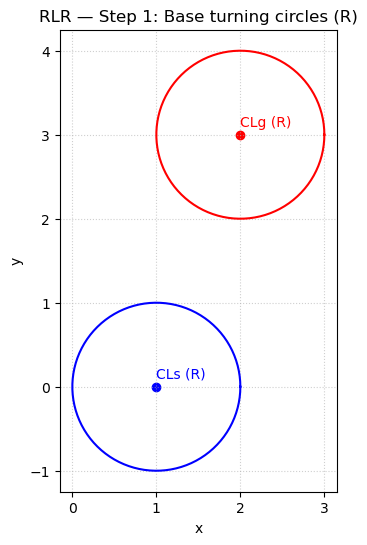


RLR example — Step 2: add helper circles of radius 2R
Center-line vector v = CLg - CLs: [1. 3.]
Center distance d = ||v||: 3.1622776601683795


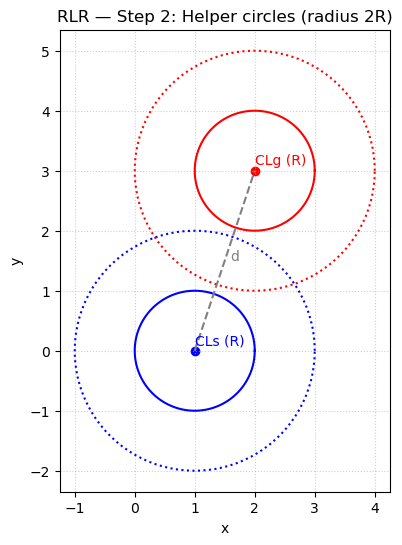


RLR example — Step 3: find intersections of helper circles
Number of intersections found: 2
Intersection 0: CM = [0.338105   1.88729833], |CLs - CM| = 2.0000, |CLg - CM| = 2.0000
Intersection 1: CM = [2.661895   1.11270167], |CLs - CM| = 2.0000, |CLg - CM| = 2.0000


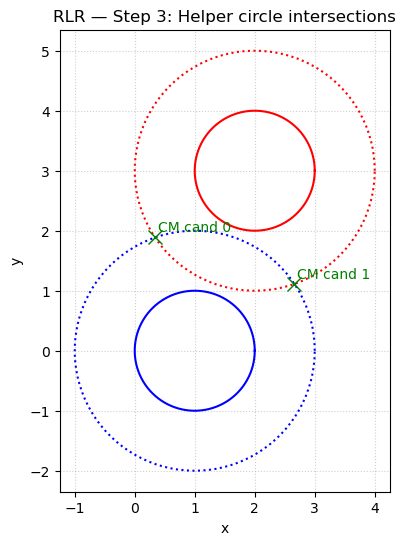


RLR example — Step 4: choose CM for middle circle
Chosen CM (for RLR): [2.661895   1.11270167]
|CLs - CM| should be ≈ 2R: 1.9999999999999996
|CLg - CM| should be ≈ 2R: 1.9999999999999998


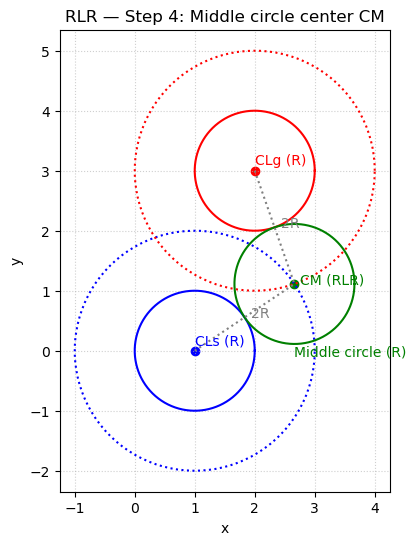

In [13]:
# ---------- RLR-style CCC example (step-by-step) ----------

R = 1.0
CLs = np.array([1.0, 0.0])   # Start R-circle center
CLg = np.array([2.0, 3.0])   # Goal  R-circle center
R_helper = 2.0 * R           # Helper circles have radius 2R

# STEP 1: Define the RLR setup and plot the base turning circles

print("RLR example — Step 1: define circle centers and radius")
print("Start R-circle center CLs:", CLs)
print("Goal  R-circle center CLg:", CLg)
print("Turning radius R:", R)
print("Helper circle radius R_helper = 2R:", R_helper)

setup_plot("RLR — Step 1: Base turning circles (R)")

# Plot the two base turning circles (R)
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Mark and label centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs (R)', color='blue')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg (R)', color='red')

plt.show()


# STEP 2: Add helper circles of radius 2R around CLs and CLg

print("\nRLR example — Step 2: add helper circles of radius 2R")

v = CLg - CLs
d = np.linalg.norm(v)
print("Center-line vector v = CLg - CLs:", v)
print("Center distance d = ||v||:", d)

setup_plot("RLR — Step 2: Helper circles (radius 2R)")

# Base circles (R)
plot_circle(CLs, R, color='blue')
plot_circle(CLg, R, color='red')

# Helper circles (2R)
plot_circle(CLs, R_helper, color='blue', style=':')
plot_circle(CLg, R_helper, color='red', style=':')

# Centers
plt.scatter(CLs[0], CLs[1], color='blue')
plt.scatter(CLg[0], CLg[1], color='red')
plt.text(CLs[0], CLs[1] + 0.1, 'CLs (R)', color='blue')
plt.text(CLg[0], CLg[1] + 0.1, 'CLg (R)', color='red')

# Center-line
plot_line(CLs, CLg, color='gray', style='--')
mid = 0.5 * (CLs + CLg)
plt.text(mid[0] + 0.1, mid[1], 'd', color='gray')

plt.show()


# STEP 3: Find the intersection points of the helper circles

print("\nRLR example — Step 3: find intersections of helper circles")

intersections = circle_intersections(CLs, R_helper, CLg, R_helper)

if not intersections:
    print("No CCC solution: helper circles do not intersect.")
else:
    print("Number of intersections found:", len(intersections))
    for i, CM in enumerate(intersections):
        print(f"Intersection {i}: CM = {CM}, "
              f"|CLs - CM| = {np.linalg.norm(CM - CLs):.4f}, "
              f"|CLg - CM| = {np.linalg.norm(CM - CLg):.4f}")

    # For this RLR example, we'll take the *second* intersection as the middle-center candidate
    if len(intersections) == 1:
        CM = intersections[0]
    else:
        CM = intersections[1]

    setup_plot("RLR — Step 3: Helper circle intersections")

    # Base circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CLg, R, color='red')

    # Helper circles
    plot_circle(CLs, R_helper, color='blue', style=':')
    plot_circle(CLg, R_helper, color='red', style=':')

    # All intersections
    for i, P in enumerate(intersections):
        plt.plot(P[0], P[1], 'gx', markersize=10)
        plt.text(P[0] + 0.05, P[1] + 0.1, f'CM cand {i}', color='green')

    plt.show()


    # STEP 4: Highlight the chosen CM and show that it is 2R from both CLs and CLg

    print("\nRLR example — Step 4: choose CM for middle circle")
    print("Chosen CM (for RLR):", CM)
    print("|CLs - CM| should be ≈ 2R:", np.linalg.norm(CM - CLs))
    print("|CLg - CM| should be ≈ 2R:", np.linalg.norm(CM - CLg))

    setup_plot("RLR — Step 4: Middle circle center CM")

    # Base circles
    plot_circle(CLs, R, color='blue')
    plot_circle(CLg, R, color='red')

    # Helper circles
    plot_circle(CLs, R_helper, color='blue', style=':')
    plot_circle(CLg, R_helper, color='red', style=':')

    # Middle circle (R) at CM
    plot_circle(CM, R, color='green')
    plt.text(CM[0], CM[1] - R - 0.2, 'Middle circle (R)', color='green')

    # Centers
    plt.scatter(CLs[0], CLs[1], color='blue')
    plt.scatter(CLg[0], CLg[1], color='red')
    plt.scatter(CM[0], CM[1], color='green')

    plt.text(CLs[0], CLs[1] + 0.1, 'CLs (R)', color='blue')
    plt.text(CLg[0], CLg[1] + 0.1, 'CLg (R)', color='red')
    plt.text(CM[0] + 0.1, CM[1], 'CM (RLR)', color='green')

    # Distances CLs–CM and CLg–CM
    plot_line(CLs, CM, color='gray', style=':')
    plot_line(CLg, CM, color='gray', style=':')

    mid1 = 0.5 * (CLs + CM)
    mid2 = 0.5 * (CLg + CM)
    plt.text(mid1[0] + 0.1, mid1[1], '2R', color='gray')
    plt.text(mid2[0] + 0.1, mid2[1], '2R', color='gray')

    plt.show()

    # (Later, you can add the actual R–L–R arcs using CLs, CM, CLg and the pose headings.)


## Computing Arc Angles on a Circle

Dubins paths require us to compute **arc lengths** on circular turning paths.
To compute an arc length, we use the classic relationship:

> arc length = R × Δθ

where:
- `R` is the turning radius, and  
- `Δθ` is the angle swept around the circle in **radians**.

This is exactly the same idea as on the unit circle (radius 1), except scaled by `R`.

---

### 1. Converting points to angles around a circle

Consider a circle with center `C` and a point `P` on that circle.

1. Form the vector from the center to the point:
   ```text
   v = P - C
   ```
2. Convert this vector to an angle using `atan2`:
   ```text
   θ = atan2(v_y, v_x)
   ```
   This gives an angle in the range `[-π, π]`.  
   In practice, we usually wrap this to `[0, 2π)` for convenience.

This angle `θ` tells us *where* around the circle the point lies.

---

### 2. CCW (Left-Turn) Arc Angle

Suppose we have two points `A` and `B` on the same circle, and we want the angle
we sweep out when we go from `A` to `B` **counter-clockwise** (CCW).

1. Compute:
   ```text
   θ_A = angle of A around the circle
   θ_B = angle of B around the circle
   ```
2. The CCW angle from `A` to `B` is:
   ```text
   Δθ_CCW = mod2pi(θ_B - θ_A)
   ```
   Here, `mod2pi` wraps angles into `[0, 2π)`.

This guarantees the result is between `0` and `2π` and always corresponds to a CCW sweep.

For Dubins, we use this when we have a **left-turn** (L):  
the robot moves counter-clockwise around the turning circle.

---

### 3. CW (Right-Turn) Arc Angle

For a **clockwise** (CW) sweep from `A` to `B`, we flip the subtraction:

```text
Δθ_CW = mod2pi(θ_A - θ_B)
```

Again, `mod2pi` keeps the result in `[0, 2π)`.

We use this for **right-turn** (R) Dubins segments, where the robot moves clockwise around the turning circle.

---

### 4. Arc length from angle

Once we have the appropriate angle difference for the chosen direction:

```text
arc_length = R * Δθ
```

- For L-segments: use `Δθ_CCW`.
- For R-segments: use `Δθ_CW`.

This works because a Dubins turning circle is just a scaled unit circle:
on a unit circle, arc length equals the angle in radians. Scaling the circle by `R`
scales all arc lengths by `R` as well.

---

### 5. Visual intuition

You can think of it this way:

- Convert both points into angles around the circle center.
- Decide whether you are moving **left** (CCW) or **right** (CW).
- Take the corresponding wrapped angle difference.
- Multiply by `R`.

This is the final missing piece for assembling full Dubins paths:
it lets us turn tangent points into precise **arc lengths** for L and R segments.

In [14]:
def mod2pi(theta):
    """Wrap angle to [0, 2π)."""
    return theta % (2 * math.pi)

def angle_on_circle(center, point):
    """
    Return the angle (0..2π) of a point around a circle center.
    """
    v = point - center
    return mod2pi(math.atan2(v[1], v[0]))

def ccw_arc_angle(center, A, B):
    """
    Angle from A to B moving CCW around the circle.
    """
    theta_A = angle_on_circle(center, A)
    theta_B = angle_on_circle(center, B)
    return mod2pi(theta_B - theta_A)

def cw_arc_angle(center, A, B):
    """
    Angle from A to B moving CW around the circle.
    """
    theta_A = angle_on_circle(center, A)
    theta_B = angle_on_circle(center, B)
    return mod2pi(theta_A - theta_B)

def arc_length(R, delta_theta):
    """Arc length for radius R and angle delta_theta (radians)."""
    return R * delta_theta


Configured angles (degrees):
  θ_A_deg = 23.0
  θ_B_deg = 99.0

Angles on circle (radians):
  θ_A = 0.4014257279586958
  θ_B = 1.7278759594743862

CCW A→B:
  Δθ_CCW = 1.3264502315156905
  arc length (R*Δθ_CCW) = 1.3264502315156905

CW A→B:
  Δθ_CW  = 4.956735075663896
  arc length (R*Δθ_CW)  = 4.956735075663896


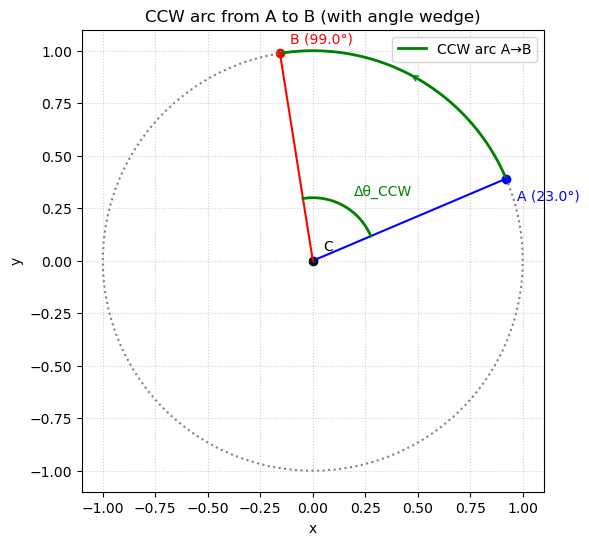

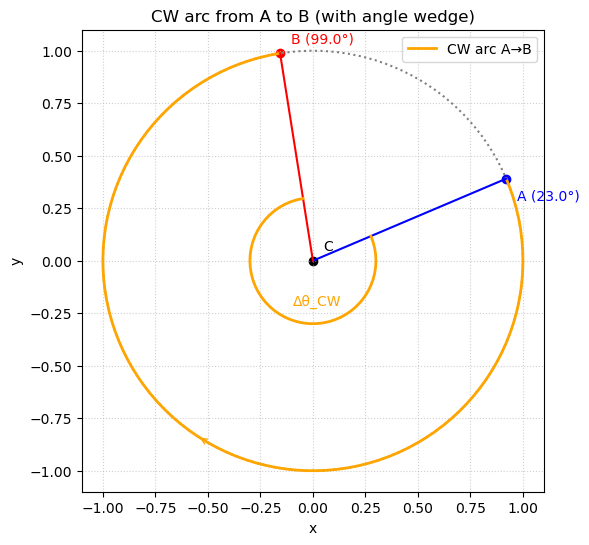

In [15]:
# === Arc angle demo: configure R, C, and angles for A and B ===

R = 1.0
C = np.array([0.0, 0.0])

# Instead of editing A/B directly, we edit their angles:
theta_A_deg = 23.0    # angle for point A (in degrees)
theta_B_deg = 99.0   # angle for point B (in degrees)

# Convert to radians
theta_A = math.radians(theta_A_deg)
theta_B = math.radians(theta_B_deg)

# Compute the points A and B on the circle of radius R around center C
A = C + R * np.array([math.cos(theta_A), math.sin(theta_A)])
B = C + R * np.array([math.cos(theta_B), math.sin(theta_B)])

# Use our helpers to recompute angles (should match theta_A/theta_B, wrapped)
theta_A_circ = angle_on_circle(C, A)
theta_B_circ = angle_on_circle(C, B)

delta_ccw = ccw_arc_angle(C, A, B)
delta_cw  = cw_arc_angle(C, A, B)

print("Configured angles (degrees):")
print("  θ_A_deg =", theta_A_deg)
print("  θ_B_deg =", theta_B_deg)

print("\nAngles on circle (radians):")
print("  θ_A =", theta_A_circ)
print("  θ_B =", theta_B_circ)

print("\nCCW A→B:")
print("  Δθ_CCW =", delta_ccw)
print("  arc length (R*Δθ_CCW) =", arc_length(R, delta_ccw))

print("\nCW A→B:")
print("  Δθ_CW  =", delta_cw)
print("  arc length (R*Δθ_CW)  =", arc_length(R, delta_cw))


# --- Plot 1: CCW arc from A to B (with angle wedge) ---

setup_plot("CCW arc from A to B (with angle wedge)")

# Full circle for context
plot_circle(C, R, color='gray', style=':')

# Sample CCW arc between A and B (outer arc)
th_start = theta_A_circ
th_end   = theta_A_circ + delta_ccw   # CCW sweep
th_arc   = np.linspace(th_start, th_end, 100)

x_arc = C[0] + R * np.cos(th_arc)
y_arc = C[1] + R * np.sin(th_arc)
plt.plot(x_arc, y_arc, color='green', linewidth=2, label='CCW arc A→B')

# Radius lines showing θ_A and θ_B
plot_line(C, A, color='blue', style='-')
plot_line(C, B, color='red',  style='-')

# Mark center, A, B with angle labels
plt.scatter(C[0], C[1], color='black')
plt.text(C[0] + 0.05, C[1] + 0.05, 'C')

plt.scatter(A[0], A[1], color='blue')
plt.text(A[0] + 0.05, A[1] - 0.1, f'A ({theta_A_deg}°)', color='blue')

plt.scatter(B[0], B[1], color='red')
plt.text(B[0] + 0.05, B[1] + 0.05, f'B ({theta_B_deg}°)', color='red')

# Small inner arc near C to represent Δθ_CCW
r_angle = 0.3 * R
th_angle = np.linspace(th_start, th_end, 50)
x_angle = C[0] + r_angle * np.cos(th_angle)
y_angle = C[1] + r_angle * np.sin(th_angle)
plt.plot(x_angle, y_angle, color='green', linewidth=2)

# Label the angle near the small arc
mid_angle = th_start + delta_ccw / 2.0
mid_point = C + r_angle * np.array([math.cos(mid_angle), math.sin(mid_angle)])
plt.text(mid_point[0] + 0.05, mid_point[1] + 0.05, 'Δθ_CCW', color='green')

# Optional: small arrow along the big CCW arc
arrow_idx = len(th_arc) // 2
p_arrow_start = np.array([x_arc[arrow_idx],     y_arc[arrow_idx]])
p_arrow_end   = np.array([x_arc[arrow_idx + 1], y_arc[arrow_idx + 1]])
plt.annotate(
    '',
    xy=p_arrow_end,
    xytext=p_arrow_start,
    arrowprops=dict(arrowstyle='->', color='green')
)

plt.legend()
plt.show()


# --- Plot 2: CW arc from A to B (with angle wedge) ---

setup_plot("CW arc from A to B (with angle wedge)")

# Full circle for context
plot_circle(C, R, color='gray', style=':')

# Sample CW arc between A and B (outer arc)
th_start = theta_A_circ
th_end   = theta_A_circ - delta_cw   # CW sweep
th_arc   = np.linspace(th_start, th_end, 100)

x_arc = C[0] + R * np.cos(th_arc)
y_arc = C[1] + R * np.sin(th_arc)
plt.plot(x_arc, y_arc, color='orange', linewidth=2, label='CW arc A→B')

# Radius lines and points again
plot_line(C, A, color='blue', style='-')
plot_line(C, B, color='red',  style='-')

plt.scatter(C[0], C[1], color='black')
plt.text(C[0] + 0.05, C[1] + 0.05, 'C')

plt.scatter(A[0], A[1], color='blue')
plt.text(A[0] + 0.05, A[1] - 0.1, f'A ({theta_A_deg}°)', color='blue')

plt.scatter(B[0], B[1], color='red')
plt.text(B[0] + 0.05, B[1] + 0.05, f'B ({theta_B_deg}°)', color='red')

# Small inner arc near C to represent Δθ_CW
r_angle = 0.3 * R
th_angle_cw = np.linspace(theta_A_circ, theta_A_circ - delta_cw, 50)
x_angle_cw = C[0] + r_angle * np.cos(th_angle_cw)
y_angle_cw = C[1] + r_angle * np.sin(th_angle_cw)
plt.plot(x_angle_cw, y_angle_cw, color='orange', linewidth=2)

mid_angle_cw = theta_A_circ - delta_cw / 2.0
mid_point_cw = C + r_angle * np.array([math.cos(mid_angle_cw), math.sin(mid_angle_cw)])
plt.text(mid_point_cw[0] + 0.05, mid_point_cw[1] + 0.05, 'Δθ_CW', color='orange')

# Small arrow along the big CW arc
arrow_idx = len(th_arc) // 2
p_arrow_start = np.array([x_arc[arrow_idx],     y_arc[arrow_idx]])
p_arrow_end   = np.array([x_arc[arrow_idx + 1], y_arc[arrow_idx + 1]])
plt.annotate(
    '',
    xy=p_arrow_end,
    xytext=p_arrow_start,
    arrowprops=dict(arrowstyle='->', color='orange')
)

plt.legend()
plt.show()


## Putting It All Together

Now that we understand the geometry for all three cases, we can write functions to solve for the path parameters `(t, p, q)`:
-   `t`: arc length of the first segment
-   `p`: length of the middle segment (arc or straight)
-   `q`: arc length of the third segment

The code below is the **full implementation**. It uses the exact geometric principles we just plotted.
-   `build_LSL`, `build_RSR` uses the "External Tangent" logic.
-   `build_LSR`, `build_RSL` uses the "Internal Tangent" logic.
-   `build_LRL`, `build_RLR` use the "CCC Radius-2 Intersection" logic.


In [16]:
import math
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

# --- Data Classes ---
# Pose is already defined above.

@dataclass
class Segment:
    kind: str      # 'L','R','S'
    param: float   # arc angle (rad, >=0) for L/R; length for S
    center: Optional[np.ndarray] = None
    start_theta: Optional[float] = None
    p0: Optional[np.ndarray] = None
    p1: Optional[np.ndarray] = None

@dataclass
class DubinsPath:
    path_type: str
    t: float  # arc length of the first segment
    p: float  # length of the middle segment (arc or straight)
    q: float  # arc length of the third segment
    length: float  # total length
    segments: List[Segment]  # should always have three segments

# --- Helper Math Functions ---
def ang(v: np.ndarray) -> float:
    return math.atan2(v[1], v[0])

def rot(v: np.ndarray, th: float) -> np.ndarray:
    c, s = math.cos(th), math.sin(th)
    return np.array([c * v[0] - s * v[1], s * v[0] + c * v[1]])

# --- Normalized Start Centers (Global Constants) ---
# In the normalized frame (Start at 0,0,0, R=1):
# The Left turn center is always at (0, 1)
CLs = np.array([0.0, 1.0])

# The Right turn center is always at (0, -1)
CRs = np.array([0.0, -1.0])

def normalize(start: Pose, goal: Pose, R: float) -> Tuple[np.ndarray, float]:
    """
    Transform the goal pose into the normalized frame relative to the start pose.

    In the normalized frame:
    1. The start position is at (0, 0).
    2. The start heading is 0.0 radians (facing +x).
    3. The turning radius is scaled to 1.0.

    Parameters
    ----------
    start : Pose
        The starting pose (x, y, heading).
    goal : Pose
        The goal pose (x, y, heading).
    R : float
        The minimum turning radius.

    Returns
    -------
    g_norm : np.ndarray
        The goal position (x, y) in the normalized frame.
    ga_norm : float
        The goal heading in the normalized frame (radians).
    """
    # 1. Translation: Shift so start is at (0,0)
    dx = goal.x - start.x
    dy = goal.y - start.y

    # 2. Rotation: Rotate by -start.heading to align start with +x axis
    # We use -heading because we are rotating the *world* into the *robot's* frame.
    # If the robot is facing 30 deg (pi/6), we rotate the world by -30 deg
    # so the robot ends up facing 0 deg.
    c = math.cos(-start.heading)
    s = math.sin(-start.heading)

    gx = c * dx - s * dy
    gy = s * dx + c * dy

    # 3. Scaling: Normalize distances by the turning radius R
    # This simplifies future math so we can assume R=1 everywhere.
    gx /= R
    gy /= R

    # 4. Heading: Normalize the relative heading
    # This is just the difference in angles.
    raw_heading_diff = goal.heading - start.heading
    ga_norm = raw_heading_diff % TAU  # Ensure it is in [0, 2pi)

    return np.array([gx, gy]), ga_norm

def goal_centers(g_norm: np.ndarray, ga_norm: float) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate the centers of the Left and Right turning circles at the goal.

    Parameters
    ----------
    g_norm : np.ndarray
        The normalized goal position [x, y].
    ga_norm : float
        The normalized goal heading in radians.

    Returns
    -------
    CL_g : np.ndarray
        The center of the Left-turn circle at the goal.
    CR_g : np.ndarray
        The center of the Right-turn circle at the goal.
    """
    # Calculate the heading vector components
    # This represents the direction the robot is facing at the goal.
    c_ga = math.cos(ga_norm)
    s_ga = math.sin(ga_norm)

    # To find the LEFT circle center:
    # We move 1 radius (R=1) to the "left" of the heading.
    # The vector (cos, sin) rotated 90 deg CCW is (-sin, cos).
    CL_g = np.array([
        g_norm[0] - s_ga,  # x - sin(theta)
        g_norm[1] + c_ga   # y + cos(theta)
    ])

    # To find the RIGHT circle center:
    # We move 1 radius (R=1) to the "right" of the heading.
    # The vector (cos, sin) rotated 90 deg CW is (sin, -cos).
    CR_g = np.array([
        g_norm[0] + s_ga,  # x + sin(theta)
        g_norm[1] - c_ga   # y - cos(theta)
    ])

    return CL_g, CR_g

def external_csc(c1: np.ndarray, c2: np.ndarray, start_turn: str, goal_turn: str,
                 g: np.ndarray, ga: float, name: str) -> Optional[DubinsPath]:
    """
    General solver for LSL and RSR paths (Common External Tangents).
    """
    v = c2 - c1
    L = np.linalg.norm(v)
    if L < 1e-12:
        return None

    u = v / L
    p_len = L  # Straight length = distance between centers

    # --- 1. Start Turn (t) ---
    r0 = -c1  # Vector from c1 to Start(0,0)

    if start_turn == 'L':
        t1 = c1 + perp_cw(u)            # Tangent point on c1
        t_raw = ang(t1 - c1) - ang(r0)  # L-turn: End - Start (CCW)
    else:  # 'R'
        t1 = c1 + perp_ccw(u)           # Tangent point on c1
        t_raw = ang(r0) - ang(t1 - c1)  # R-turn: Start - End (CW)

    # FIXED: Use mod2pi for minimal positive arc length
    t_ang = mod2pi(t_raw)
    seg0 = Segment(start_turn, t_ang, center=c1, start_theta=ang(r0))

    # --- 2. Goal Turn (q) ---
    r_goal = g - c2  # Vector from c2 to Goal

    if goal_turn == 'L':
        t2 = c2 + perp_cw(u)            # Tangent point on c2
        q_raw = ang(r_goal) - ang(t2 - c2)
    else:  # 'R'
        t2 = c2 + perp_ccw(u)           # Tangent point on c2
        q_raw = ang(t2 - c2) - ang(r_goal)

    # FIXED: Use mod2pi for minimal positive arc length
    q_ang = mod2pi(q_raw)
    seg2 = Segment(goal_turn, q_ang, center=c2, start_theta=ang(t2 - c2))

    # --- 3. Assemble ---
    seg1 = Segment('S', p_len, p0=t1, p1=t2)
    total = t_ang + p_len + q_ang

    return DubinsPath(name, t_ang, p_len, q_ang, total, [seg0, seg1, seg2])

def shortest_arc(angle_diff: float) -> float:
    """
    Return the smallest non-negative central angle corresponding to `angle_diff`.
    
    Geometrically: this is the length of the shorter arc between the two rays
    defined by the angles, regardless of CW/CCW direction. The turn direction
    is already encoded by the segment kind ('L' or 'R'), so here we only care
    about arc length (0 <= result <= pi).
    """
    a = mod2pi(angle_diff)   # put into [0, 2π)
    return a if a <= math.pi else TAU - a

def internal_csc(
    c1: np.ndarray,
    c2: np.ndarray,
    start_turn: str,
    goal_turn: str,
    g: np.ndarray,
    ga: float,
    name: str
) -> Optional[DubinsPath]:
    v = c2 - c1
    L = np.linalg.norm(v)
    print("L =", L)

    # Need enough separation for internal tangent: L > 2R (R=1)
    if L < 2.0 - 1e-12:
        return None

    u = v / L
    beta = math.asin(min(1.0, 2.0 / L))  # sin(beta) = 2R / L, R=1
    best = None
    tol = 1e-6

    for sgn in (+1.0, -1.0):
        w = rot(u, sgn * beta)

        # ------------------------------------------------
        # 1) Tangent points t1, t2 from direction w
        # ------------------------------------------------
        if start_turn == 'L':
            t1 = c1 + perp_cw(w)
        else:  # 'R'
            t1 = c1 + perp_ccw(w)

        if goal_turn == 'L':
            t2 = c2 + perp_cw(w)
        else:  # 'R'
            t2 = c2 + perp_ccw(w)

        # Check they lie on the circles (radius ~ 1)
        r1 = t1 - c1
        r2 = t2 - c2
        if abs(np.linalg.norm(r1) - 1.0) > tol or abs(np.linalg.norm(r2) - 1.0) > tol:
            # Numerical safety, but with your math this should be fine
            continue

        # Check true tangency: line is perpendicular to radius at each point
        line = t2 - t1
        if abs(np.dot(line, r1)) > tol or abs(np.dot(line, r2)) > tol:
            # This is the non-tangent branch; skip it
            continue

        # ------------------------------------------------
        # 2) Start arc (t) – use proper mod2pi, no "shortest arc" hack
        # ------------------------------------------------
        r0 = -c1  # vector from c1 to start pose (start is at origin)

        theta_r0 = ang(r0)
        theta_t1 = ang(r1)

        if start_turn == 'L':
            # CCW: end - start
            t_ang = mod2pi(theta_t1 - theta_r0)
        else:  # 'R'
            # CW: start - end
            t_ang = mod2pi(theta_r0 - theta_t1)

        seg0 = Segment(start_turn, t_ang, center=c1, start_theta=theta_r0)

        # ------------------------------------------------
        # 3) Goal arc (q)
        # ------------------------------------------------
        r_goal = g - c2
        theta_goal = ang(r_goal)
        theta_t2 = ang(r2)

        if goal_turn == 'L':
            # CCW: end - start
            q_ang = mod2pi(theta_goal - theta_t2)
        else:  # 'R'
            # CW: start - end
            q_ang = mod2pi(theta_t2 - theta_goal)

        seg2 = Segment(goal_turn, q_ang, center=c2, start_theta=theta_t2)

        # ------------------------------------------------
        # 4) Straight segment (p) – must be positive
        # ------------------------------------------------
        p_len = float(np.dot(v, w))  # = L * cos(beta) = sqrt(L^2 - 4)

        if p_len < 1e-12:
            continue

        seg1 = Segment('S', p_len, p0=t1, p1=t2)

        # Debug so you can see what's happening
        print(
            f"Candidate {name} (sgn={sgn}): "
            f"t_ang={t_ang:.4f}, p_len={p_len:.4f}, q_ang={q_ang:.4f}"
        )

        total = t_ang + p_len + q_ang
        cand = DubinsPath(name, t_ang, p_len, q_ang, total, [seg0, seg1, seg2])

        if (best is None) or (cand.length < best.length):
            best = cand

    return best

def solve_ccc(c1: np.ndarray, c2: np.ndarray, start_turn: str, mid_turn: str, goal_turn: str,
              g: np.ndarray, ga: float, name: str) -> Optional[DubinsPath]:
    """
    General solver for LRL and RLR paths (Circle-Circle-Circle).
    """
    centers = circle_intersections(c1, 2.0, c2, 2.0)
    if not centers:
        return None

    best_path = None

    for cm in centers:
        # Tangent points are midpoints between centers
        t1 = 0.5 * (c1 + cm)
        t2 = 0.5 * (cm + c2)

        # --- Start Turn (t) ---
        r0 = -c1
        t_raw = ang(t1 - c1) - ang(r0) if start_turn == 'L' else ang(r0) - ang(t1 - c1)
        t_ang = mod2pi(t_raw)  # FIXED: Use mod2pi
        seg0 = Segment(start_turn, t_ang, center=c1, start_theta=ang(r0))

        # --- Middle Turn (p) ---
        v1 = t1 - cm
        v2 = t2 - cm
        p_raw = ang(v2) - ang(v1) if mid_turn == 'L' else ang(v1) - ang(v2)
        p_ang = mod2pi(p_raw)  # FIXED: Use mod2pi
        seg1 = Segment(mid_turn, p_ang, center=cm, start_theta=ang(v1))

        # --- Goal Turn (q) ---
        r_goal = g - c2
        q_raw = ang(r_goal) - ang(t2 - c2) if goal_turn == 'L' else ang(t2 - c2) - ang(r_goal)
        q_ang = mod2pi(q_raw)  # FIXED: Use mod2pi
        seg2 = Segment(goal_turn, q_ang, center=c2, start_theta=ang(t2 - c2))

        # Assemble
        total = t_ang + p_ang + q_ang
        cand = DubinsPath(name, t_ang, p_ang, q_ang, total, [seg0, seg1, seg2])

        if best_path is None or cand.length < best_path.length:
            best_path = cand

    return best_path

def build_LSL(g: np.ndarray, ga: float) -> Optional[DubinsPath]:
    """
    Build the Left-Straight-Left path.
    Uses Start Left Center (CLs) and Goal Left Center (CLg).
    """
    CLg, _ = goal_centers(g, ga)

    # Sequence: L -> L (External Tangent)
    return external_csc(CLs, CLg, 'L', 'L', g, ga, 'LSL')

def build_RSR(g: np.ndarray, ga: float) -> Optional[DubinsPath]:
    """
    Build the Right-Straight-Right path.
    Uses Start Right Center (CRs) and Goal Right Center (CRg).
    """
    _, CRg = goal_centers(g, ga)

    # Sequence: R -> R (External Tangent)
    return external_csc(CRs, CRg, 'R', 'R', g, ga, 'RSR')

def build_LSR(g: np.ndarray, ga: float) -> Optional[DubinsPath]:
    """
    Build the Left-Straight-Right path.
    Uses Start Left Center (CLs) and Goal Right Center (CRg).
    """
    _, CRg = goal_centers(g, ga)
    # Start=L, Goal=R
    return internal_csc(CLs, CRg, 'L', 'R', g, ga, 'LSR')

def build_RSL(g: np.ndarray, ga: float) -> Optional[DubinsPath]:
    """
    Build the Right-Straight-Left path.
    Uses Start Right Center (CRs) and Goal Left Center (CLg).
    """
    CLg, _ = goal_centers(g, ga)
    # Start=R, Goal=L
    return internal_csc(CRs, CLg, 'R', 'L', g, ga, 'RSL')

def build_LRL(g: np.ndarray, ga: float) -> Optional[DubinsPath]:
    """
    Build the Left-Right-Left path.
    Uses Start Left Center (CLs) and Goal Left Center (CLg).
    """
    CLg, _ = goal_centers(g, ga)
    # Sequence: L -> R -> L
    return solve_ccc(CLs, CLg, 'L', 'R', 'L', g, ga, 'LRL')

def build_RLR(g: np.ndarray, ga: float) -> Optional[DubinsPath]:
    """
    Build the Right-Left-Right path.
    Uses Start Right Center (CRs) and Goal Right Center (CRg).
    """
    _, CRg = goal_centers(g, ga)
    # Sequence: R -> L -> R
    return solve_ccc(CRs, CRg, 'R', 'L', 'R', g, ga, 'RLR')


### Final Solver and Plotting

This final set of functions puts everything together.
- `solve_all`: Tries all 6 builders and returns the results.
- `plot_solution`: A function to draw the final path in the "world" frame.
- `build_and_verify`: The main function that finds the *shortest* path and checks it for errors.

In [17]:
def solve_all(g_norm: np.ndarray, ga_norm: float) -> Dict[str, Optional[DubinsPath]]:
    """
    Attempt to build all 6 path types for a given normalized goal.
    """
    return {
        'LSL': build_LSL(g_norm, ga_norm),
        'RSR': build_RSR(g_norm, ga_norm),
        'LSR': build_LSR(g_norm, ga_norm),
        'RSL': build_RSL(g_norm, ga_norm),
        'RLR': build_RLR(g_norm, ga_norm),
        'LRL': build_LRL(g_norm, ga_norm),
    }

def finalize_segments(sol: DubinsPath):
    """
    Populate the start_theta, p0, and p1 fields for each segment 
    so they can be easily plotted.
    """
    # Start at the normalized origin (0,0) with heading 0
    pos = np.array([0.0, 0.0])
    yaw = 0.0
    
    for seg in sol.segments:
        if seg.kind in ('L', 'R'):
            # Arc Segment
            seg.center = seg.center if seg.center is not None else np.zeros(2)
            seg.start_theta = ang(pos - seg.center)
            
            is_left = (seg.kind == 'L')
            # Calculate end angle
            theta_end = seg.start_theta + (seg.param if is_left else -seg.param)
            
            # Update position to end of arc
            pos = seg.center + np.array([math.cos(theta_end), math.sin(theta_end)])
            # Update heading (tangent to circle)
            yaw = theta_end + (math.pi/2 if is_left else -math.pi/2)
            
        else:
            # Straight Segment
            if seg.p0 is None: 
                seg.p0 = pos.copy()
            
            # Calculate end point p1 based on length (param) and current yaw
            if seg.p1 is None:
                seg.p1 = seg.p0 + seg.param * np.array([math.cos(yaw), math.sin(yaw)])
            
            pos = seg.p1.copy()
            # Yaw does not change on a straight line

def trace_end_pose(solution: DubinsPath) -> Tuple[np.ndarray, float]:
    """
    Trace the path to find the final normalized position and heading.
    """
    pos = np.array([0.0, 0.0])
    yaw = 0.0
    
    for seg in solution.segments:
        if seg.kind in ('L', 'R'):
            is_left = (seg.kind == 'L')
            theta_start = seg.start_theta
            theta_end = theta_start + (seg.param if is_left else -seg.param)
            
            pos = seg.center + np.array([math.cos(theta_end), math.sin(theta_end)])
            yaw = theta_end + (math.pi/2 if is_left else -math.pi/2)
        else:
            pos = seg.p1.copy()
            
    return pos, mod2pi(yaw)

def build_and_verify(start: Pose, goal: Pose, R: float) -> Tuple[str, Optional[DubinsPath], float, float]:
    """
    Find the shortest valid Dubins path among all 6 types.
    Returns: (best_type_name, best_path_obj, pos_error, yaw_error)
    """
    # 1. Normalize
    g_norm, ga_norm = normalize(start, goal, R)
    
    # 2. Solve all types
    candidates = solve_all(g_norm, ga_norm)
    
    best = None
    
    for name, sol in candidates.items():
        if sol is None:
            continue
            
        # 3. Finalize and Trace
        finalize_segments(sol)
        epos, eyaw = trace_end_pose(sol)
        
        plot_solution(start, goal, R, sol, f"{name}")

        
        # 4. Check Errors (in normalized frame)
        pos_err = float(np.linalg.norm(epos - g_norm))
        yaw_err = float(min(mod2pi(eyaw - ga_norm), mod2pi(ga_norm - eyaw)))
        
        # Filter out invalid paths (should be handled by logic, but good as a safety net)
        if pos_err > 1e-4 or yaw_err > 1e-4:
            # print(f"Skipping {name}: High error (p={pos_err:.1e}, a={yaw_err:.1e})")
            continue
                        
        # 5. Pick Shortest
        if (best is None) or (sol.length < best[1].length):
            best = (name, sol, pos_err, yaw_err)
            
    if best is None:
        return "No Path", None, 0.0, 0.0
        
    return best

def plot_solution(start: Pose, goal: Pose, R: float, sol: DubinsPath, title_prefix: str = ""):
    """
    Plot the full Dubins solution in the world frame with enhanced visualization.
    """
    # 1. Setup Plot
    total_len = sol.length * R
    full_title = f"{title_prefix} | R={R:.1f} | Total Dist={total_len:.2f}"
    setup_plot(full_title)
    
    # 2. Helper: Calculate World Frame Circle Centers
    def get_circles(p: Pose):
        # Heading vector (cos, sin)
        c, s = math.cos(p.heading), math.sin(p.heading)
        # Left center: (+R * normal_left) -> normal_left is (-sin, cos)
        cl = np.array([p.x - R*s, p.y + R*c])
        # Right center: (+R * normal_right) -> normal_right is (sin, -cos)
        cr = np.array([p.x + R*s, p.y - R*c])
        return cl, cr

    CLs, CRs = get_circles(start)
    CLg, CRg = get_circles(goal)
    
    # 3. Determine which circles were used based on path type
    # Path type is string like 'LSL', 'RSR', etc.
    # Seg 1 uses Start circles, Seg 3 uses Goal circles.
    start_turn = sol.path_type[0] # 'L' or 'R'
    goal_turn  = sol.path_type[2] # 'L' or 'R'
    
    # Define styles
    used_style   = {'color': 'black',   'linestyle': '--', 'alpha': 0.8, 'linewidth': 0.8}
    unused_style = {'color': 'dimgray', 'linestyle': ':',  'alpha': 0.5, 'linewidth': 0.5}
    
    # Plot Start Circles
    plot_circle(CLs, R, **(used_style if start_turn == 'L' else unused_style))
    plot_circle(CRs, R, **(used_style if start_turn == 'R' else unused_style))
    
    # Plot Goal Circles
    plot_circle(CLg, R, **(used_style if goal_turn == 'L' else unused_style))
    plot_circle(CRg, R, **(used_style if goal_turn == 'R' else unused_style))
    
    # 4. Helper to convert normalized points to world points for the path
    def to_world(p_norm):
        x_s, y_s = p_norm[0] * R, p_norm[1] * R
        c, s = math.cos(start.heading), math.sin(start.heading)
        return np.array([c*x_s - s*y_s + start.x, s*x_s + c*y_s + start.y])

    # 5. Plot Path Segments with Lengths in Legend
    colors = ['tab:green', 'tab:orange', 'tab:red']
    
    for i, seg in enumerate(sol.segments):
        seg_length_world = seg.param * R
        label_str = f"Seg {i+1} ({seg.kind}): {seg_length_world:.2f}"
        
        if seg.kind in ('L', 'R'):
            # Sample arc
            is_left = (seg.kind == 'L')
            ts = np.linspace(0, seg.param, 50)
            thetas = seg.start_theta + (ts if is_left else -ts)
            
            # Arc points (normalized) -> World
            arc_x = seg.center[0] + np.cos(thetas)
            arc_y = seg.center[1] + np.sin(thetas)
            pts = np.array([to_world(np.array([x, y])) for x, y in zip(arc_x, arc_y)])
            plt.plot(pts[:,0], pts[:,1], color=colors[i], linewidth=2.5, label=label_str)
            
        else:
            # Straight segment
            p0 = to_world(seg.p0)
            p1 = to_world(seg.p1)
            plot_line(p0, p1, color=colors[i], style='-')
            # Draw line again just for legend labeling (plot_line doesn't support label arg in all versions)
            plt.plot([p0[0], p1[0]], [p0[1], p1[1]], color=colors[i], linewidth=2.5, label=label_str)

    # 6. Plot Start/Goal Arrows & Annotations
    plot_arrow(np.array([start.x, start.y]), start.heading, length=R, color='black')
    plt.scatter(start.x, start.y, color='green', zorder=5)
    plt.text(start.x, start.y - R*0.4, "Start", fontweight='bold', ha='center')
    
    plot_arrow(np.array([goal.x, goal.y]), goal.heading, length=R, color='black')
    plt.scatter(goal.x, goal.y, color='red', zorder=5)
    plt.text(goal.x, goal.y - R*0.4, "Goal", fontweight='bold', ha='center')

    # Add text box for Start Pose details
    start_info = f"Start Pose:\nx={start.x:.2f}\ny={start.y:.2f}\nθ={math.degrees(start.heading):.1f}°"
    plt.text(0.02, 0.98, start_info, transform=plt.gca().transAxes,
             fontsize=9, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    plt.legend(loc='best', fontsize='small')
    plt.show()

## Try It Yourself!

Now you can run the full solver.
**REMEMBER:** The `Pose` class expects `heading` in **RADIANS**, not degrees.
Use `math.radians(degrees)` to convert.

L = 2.714748473358655
Candidate LSR (sgn=1.0): t_ang=0.6838, p_len=1.8357, q_ang=4.4537
L = 1.5109472650579008


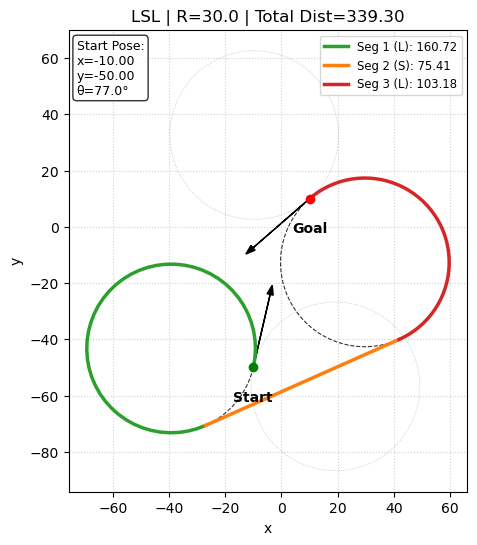

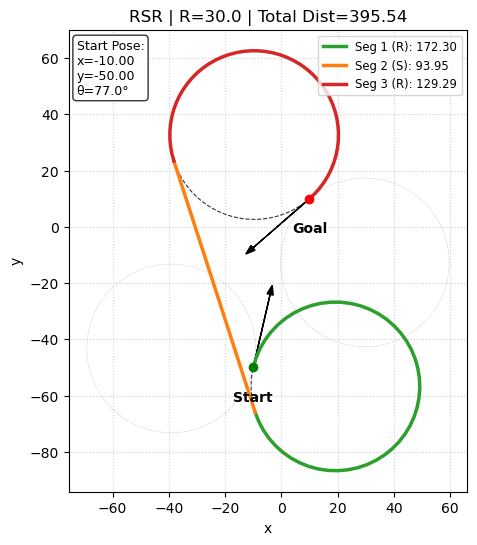

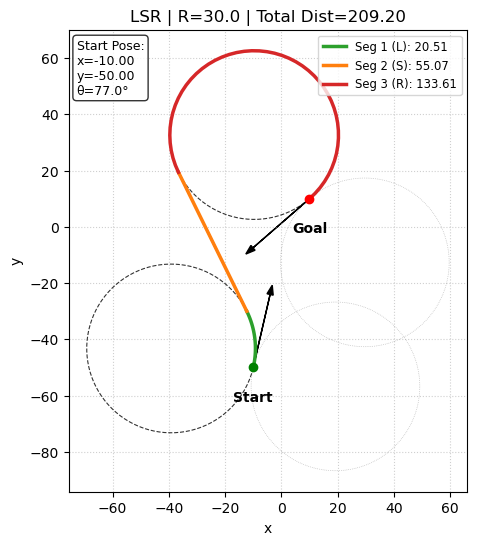

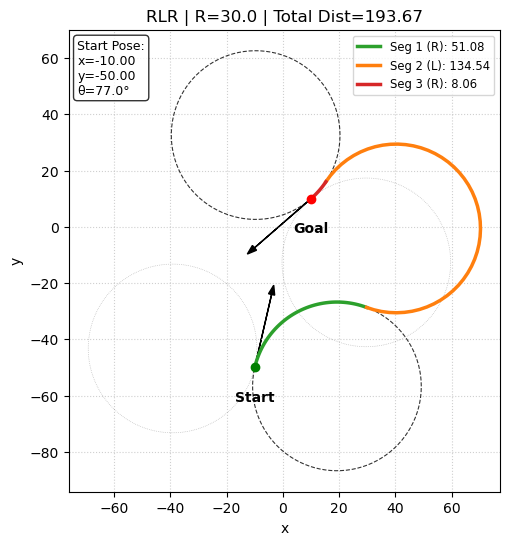

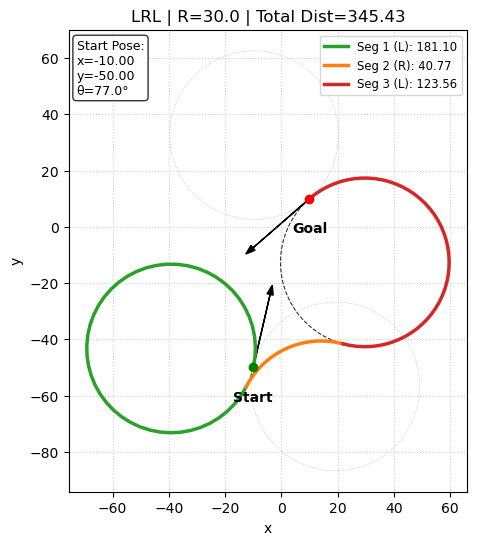

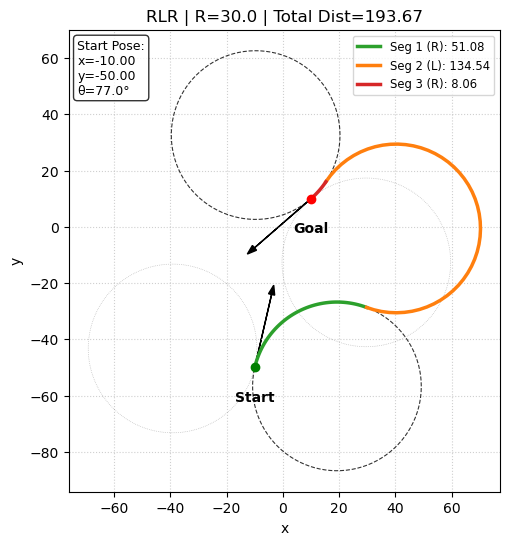

In [18]:

# --- Try your own inputs ---
# NOTE: math.radians() is your friend!

R = 30.0
start = Pose(-10.0, -50.0, math.radians(77.0))
goal  = Pose(10.0, 10.0, math.radians(221.0))

# --- Run simulation ---
name, sol, pe, ye = build_and_verify(start, goal, R)

if sol is not None:
    plot_solution(start, goal, R, sol, f"{name}")
else:
    print(f"Could not find a valid Dubins path for this configuration.")


L = 5.599708431705733
Candidate LSR (sgn=1.0): t_ang=5.2657, p_len=5.2304, q_ang=4.0265
L = 2.9722763980829985
Candidate RSL (sgn=-1.0): t_ang=2.5969, p_len=2.1987, q_ang=3.8361


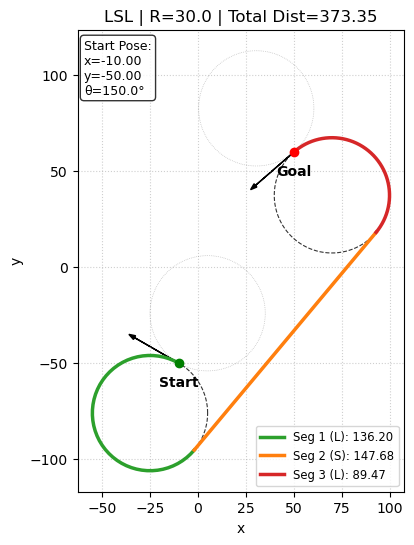

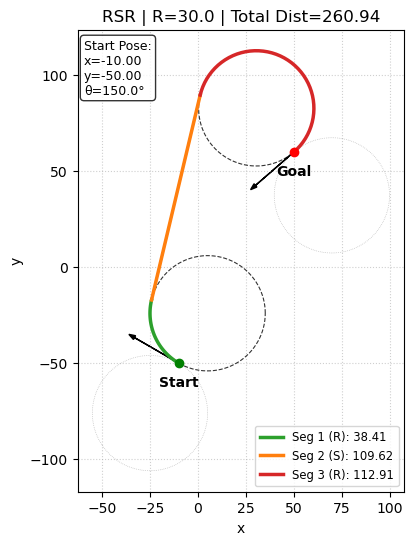

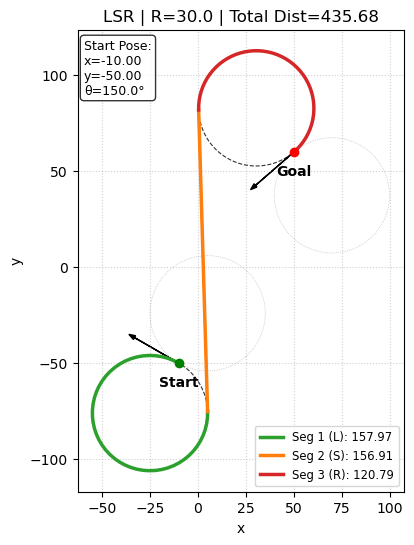

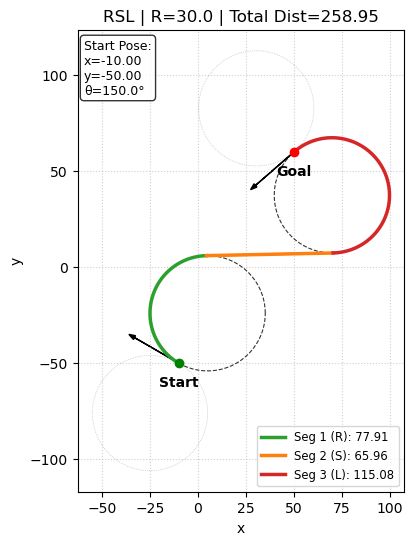

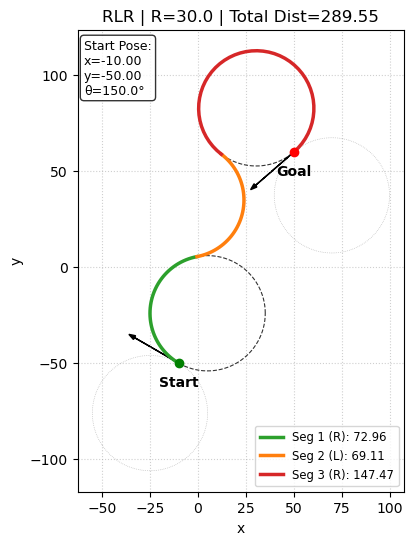

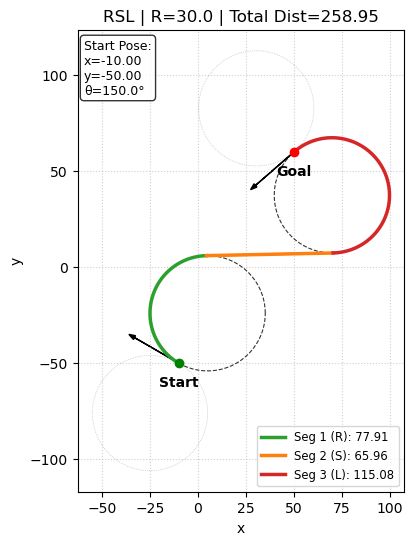

In [19]:
R = 30.0
start = Pose(-10.0, -50.0, math.radians(150.0))
goal  = Pose(50.0, 60.0, math.radians(221.0))

# --- Run simulation ---
name, sol, pe, ye = build_and_verify(start, goal, R)

if sol is not None:
    plot_solution(start, goal, R, sol, f"{name}")
else:
    print(f"Could not find a valid Dubins path for this configuration.")

L = 2.3098638220194045
Candidate LSR (sgn=1.0): t_ang=4.3581, p_len=1.1556, q_ang=0.6929
L = 1.2825256149615873


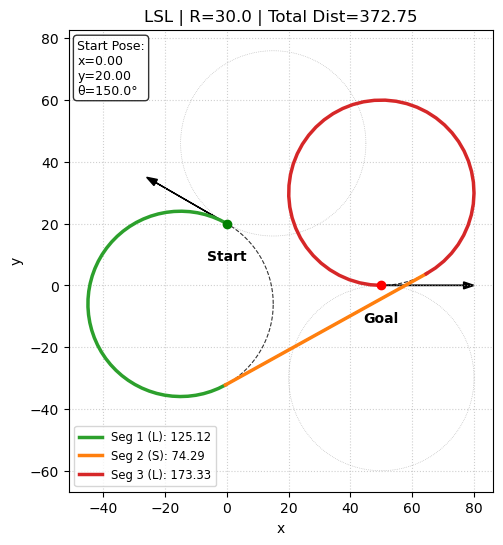

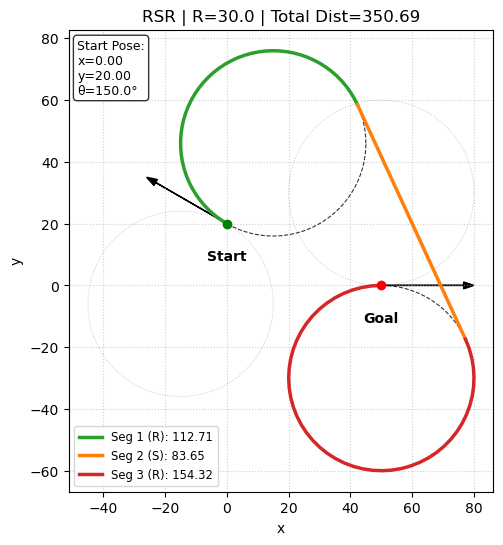

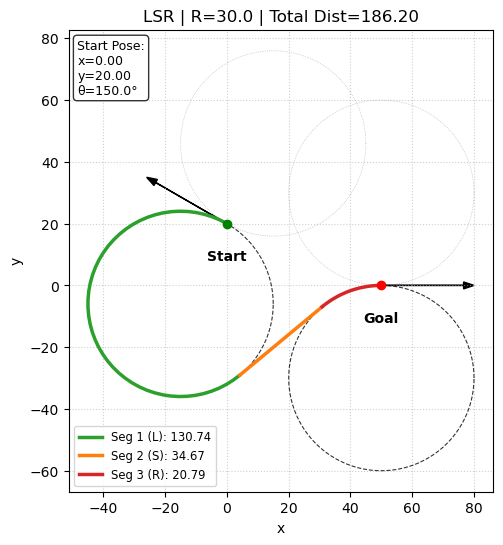

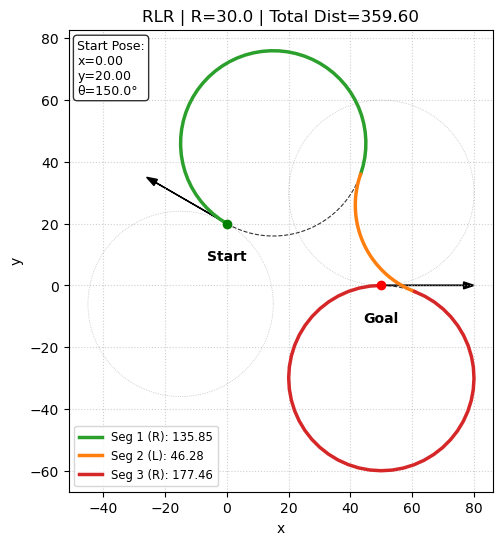

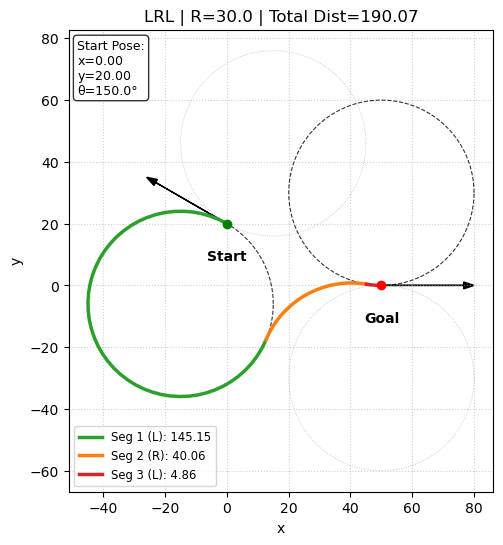

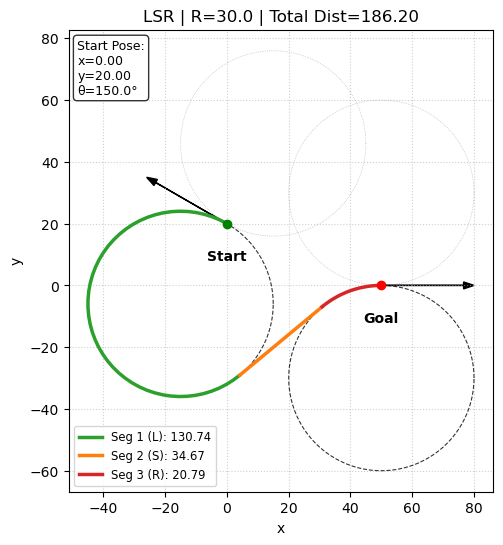

In [20]:
R = 30.0
start = Pose(0.0, 20.0, math.radians(150.0))
goal  = Pose(50.0, 0.0, math.radians(0.0))

# --- Run simulation ---
name, sol, pe, ye = build_and_verify(start, goal, R)

if sol is not None:
    plot_solution(start, goal, R, sol, f"{name}")
else:
    print(f"Could not find a valid Dubins path for this configuration.")